In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
from sklearn.metrics import roc_auc_score, roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

super_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4"
pocket_fit_folder=f"{super_folder}/morphing_annealing_4d09_filtered_subset/"
folder=f"{pocket_fit_folder}/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG"
step0_db_file=f"{pocket_fit_folder}/ddG_step_0_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step0_dG.pickle"

settings_folder=folder+"/meta_param_search/settings/"
os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol

import sys
sys.path.append(folder)
sys.path.append(folder+"/meta_param_search/")
sys.path.append(folder+"/../")

In [199]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# debug

In [ ]:
# p_mask=np.array([[0,1,0,4],[2,3,7,4],[1,6,0,4]])
# p_mask = np.logical_and(np.logical_and(p_mask[0], p_mask[1]), p_mask[2]) # bundle mask for all axis together
# print(p_mask)

In [ ]:
# import h5py
# X=[]
# with h5py.File(pocket_fit_folder+'/2D_repr_no_core.hdf5', "r") as hdf:
#     l=hdf['2D/set4_0'][:]
#     print(type(l))

In [ ]:
# import oddt
# from oddt import toolkit, fingerprints, interactions

# protein=next(toolkit.readfile( 'pdb', f"{pocket_fit_folder}/data/setup/prot.pdb"))
# protein.protein = True

# #ligand=next(toolkit.oddt.toolkits.rdk.Molecule( set_0_ligs[0] ))
# ligand=toolkit.readstring('pdb', Chem.rdmolfiles.MolToPDBBlock(set_0_ligs[0]))
# IFP = fingerprints.InteractionFingerprint( ligand, protein)
# print(IFP)
# print(IFP.shape)

In [ ]:
# DS.no_core_PLEC_contact_filter

In [ ]:
set_0_ligs[0].GetProp("[Q] hPDE2_pIC50")

# Define representation blocks

In [3]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset

base_flags=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.EState_FP, dataBlocks.Graph_desc, dataBlocks.Pharmacophore_feature_map]
extras_flags=[dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
              dataBlocks.AUTOCORR3D, dataBlocks.BCUT2D, dataBlocks.WHIM, dataBlocks.RDF,
              dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
              dataBlocks.SlogP_VSA, dataBlocks.MORSE]
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

no_core_base_flags=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_EState_FP, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_Pharmacophore_feature_map]
no_core_extras_flags=[dataBlocks.no_core_MOE, dataBlocks.no_core_MQN, dataBlocks.no_core_GETAWAY, dataBlocks.no_core_AUTOCORR2D,
              dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_BCUT2D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
              dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT, dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
              dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]
no_core_flags_2D=[dataBlocks.no_core_MACCS, dataBlocks.no_core_Descriptors, dataBlocks.no_core_Graph_desc, dataBlocks.no_core_BCUT2D]
no_core_flags_3D=[dataBlocks.no_core_EState_FP, dataBlocks.no_core_Pharmacophore_feature_map,
          dataBlocks.no_core_MOE, dataBlocks.no_core_MQN,
          dataBlocks.no_core_GETAWAY,
          dataBlocks.no_core_AUTOCORR2D,
          dataBlocks.no_core_AUTOCORR3D, dataBlocks.no_core_WHIM, dataBlocks.no_core_RDF,
          #dataBlocks.no_core_USR, dataBlocks.no_core_USRCUT,
          dataBlocks.no_core_PEOE_VSA, dataBlocks.no_core_SMR_VSA,
          dataBlocks.no_core_SlogP_VSA, dataBlocks.no_core_MORSE]

# prepare settings

In [113]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=2000
hl_w=300
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

#impfilt=0.0075
#impfilt=0.01
#X_filter=folder+"/models/MACCS_w_desc2featmap_ESP_full_grid_w_atom_hot/known_1044_width_120_depth_2_trd_0_wd_0.001_norm_X/"+f"/Xfilter_importance_over_{impfilt}.pickle"
#X_filter="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/adaptive_learning_test_from_morphed_structs/models/MACCS_w_desc2featmap_w_extras/known_2088_width_120_depth_2_trd_10000_wd_0.001_norm_X_weightedbyY_dropout0.5_shiftY/"+f"/Xfilter_importance_over_{impfilt}.pickle"

# h="82602"
# impfilt=f"hash_{h}"
# combined_filter_folder=folder+"models/MACCS_w_desc2featmap_ESP_full_grid_w_atom_hot_w_extras/"
# X_filter=combined_filter_folder+f"/Xfilter_combined_hash_{h}.pickle"
# if(not os.path.exists(X_filter)):
#     raise(Exception(f"No such file: {X_filter}"))

weighted=True
use_dropout=True
shiftY=True



settings=[
    representation_flags, dr_name, normalize_x, shuffle_seed,
    n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
    impfilt, X_filter,
    weighted, shiftY, use_dropout
]

In [ ]:


# sha = hashlib.sha256()
# sha.update(pickle.dumps(settings))
# settings_hash=sha.hexdigest()[:10]

# settings_fname=settings_folder+f"{settings_hash}.pickle"
# if(os.path.exists(settings_fname)):
#     with open(settings_fname, 'rb') as f:
#         settings_loaded, metrics = pickle.load(f)
#         if(metrics is not None and not redo):
#             print(f"{settings_fname} is already trained.")
#         else:
#             print(f"{settings_fname} exists but is not trained yet.")
# else:
#     pickle.dump( (settings, None), open( settings_fname, "wb" ) )

# scan through representations individually (using the 99 step_0 ddG ligs)
and without caching

In [ ]:
with open(set0_db_file, 'rb') as f:
    set_0_ligs = pickle.load(f)

In [ ]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=2000
hl_w=300
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True



block_names_full=["2D", "3D", "PLEC", "PLEC_filtered", "MDenerg", "MDenerg_long_cut", "MDenerg_binned", "MDenerg_long_cut_binned", "atom_hot", "atom_hot_surf"]
# import itertools
# l = [False, True]
# combs_full=list(itertools.product(l, repeat=len(block_names_full)))
# print(len(combs_full))


# for c in combs_full:
for k in range(len(block_names_full)):
    c=[False]*len(block_names_full)
    c[k]=True
    b_2D, b_3D, b_PLEC, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)!=1:
        continue # only do the individual ones
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    if(b_2D):
        for b in flags_2D:
            representation_flags[int(b)]=1
    if(b_3D):
        for b in flags_3D:
            representation_flags[int(b)]=1
    if(b_PLEC):
        representation_flags[int(dataBlocks.PLEC)]=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.MDenerg_longcut)]=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.MDenerg_binned)]=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.MDenerg_longcut_binned)]=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.atom_hot_on_vdw_surf)]=1
#     else:
#         continue

    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    print(f"{dr_name:40s}", end="")
    DS=CustomMolModularDataset(ligs=set_0_ligs, representation_flags=representation_flags, normalize_x=False, use_cache=False)
#     print()
#     print(DS.gridsize)
#     print(DS.min_coords, DS.max_coords)
#     print(DS.resolution)
    
#     print(DS.vdw_points)
#     print(np.min(DS.vdw_points, axis=0), np.max(DS.vdw_points, axis=0))
    #print(DS.ligs[0].GetConformer().GetPositions())
    
    
    print(f"width:\t{DS[0][0].shape}")
    

In [ ]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=2000
hl_w=300
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True



block_names_no_core=["no_core_2D", "no_core_3D", "no_core_PLEC", "no_core_PLEC_filtered", "no_core_MDenerg",
                     "no_core_MDenerg_long_cut", "no_core_MDenerg_binned",
                     "no_core_MDenerg_long_cut_binned",
                     "no_core_atom_hot", "no_core_atom_hot_surf"]
# import itertools
# l = [False, True]
# combs_full=list(itertools.product(l, repeat=len(block_names_full)))
# print(len(combs_full))


# for c in combs_full:
for k in range(len(block_names_no_core)):
    c=[False]*len(block_names_no_core)
    c[k]=True
    b_2D, b_3D, b_PLEC, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)!=1:
        continue # only do the individual ones
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    if(b_2D):
        for b in no_core_flags_2D:
            representation_flags[int(b)]=1
    if(b_3D):
        for b in no_core_flags_3D:
            representation_flags[int(b)]=1
    if(b_PLEC):
        representation_flags[int(dataBlocks.no_core_PLEC)]=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.no_core_PLEC_filtered)]=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.no_core_MDenerg)]=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut)]=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_binned)]=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut_binned)]=1
    if(b_ah):
        representation_flags[int(dataBlocks.no_core_atom_hot)]=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.no_core_atom_hot_on_vdw_surf)]=1
#     else:
#         continue

    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_no_core[i]+'_'
    dr_name=dr_name[:-1]
    
    print(f"{dr_name:40s}", end="")
    DS=CustomMolModularDataset(ligs=set_0_ligs, representation_flags=representation_flags, normalize_x=False, use_cache=False)
#     print()
#     print(DS.gridsize)
#     print(DS.min_coords, DS.max_coords)
#     print(DS.resolution)
    
#     print(DS.vdw_points)
#     print(np.min(DS.vdw_points, axis=0), np.max(DS.vdw_points, axis=0))
    #print(DS.ligs[0].GetConformer().GetPositions())
    
    
    print(f"width:\t{DS[0][0].shape}")
    

# Build caches for all the individual represenations

### load the full 34k ligs and the no_core versions

In [230]:
all_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_with_2D_no_core_tSNE_and_step0_dG.pickle"
all_no_core_ligs_db_file=f"{pocket_fit_folder}/filtered_subset_without_weird_chemistry_no_core_ligs_with_step0_dG.pickle"

with open(all_ligs_db_file, 'rb') as f:
    ligs_set4f = pickle.load(f)
    
with open(all_no_core_ligs_db_file, 'rb') as f:
    no_core_ligs_set4f = pickle.load(f)

### Cache the full lig representations

In [ ]:
block_names_full=["2D", "3D", "PLEC", "PLEC_filtered", "MDenerg", "MDenerg_long_cut", "MDenerg_binned", "MDenerg_long_cut_binned", "atom_hot", "atom_hot_surf"]

# for c in combs_full:
for k in range(len(block_names_full)):
    c=[False]*len(block_names_full)
    c[k]=True
    b_2D, b_3D, b_PLEC, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)!=1:
        continue # only do the individual ones
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    if(b_2D):
        for b in flags_2D:
            representation_flags[int(b)]=1
    if(b_3D):
        for b in flags_3D:
            representation_flags[int(b)]=1
    if(b_PLEC):
        representation_flags[int(dataBlocks.PLEC)]=1
    else:
        continue
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.MDenerg_longcut)]=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.MDenerg_binned)]=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.MDenerg_longcut_binned)]=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.atom_hot_on_vdw_surf)]=1
    

    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    print(f"{dr_name:40s}", end="")
    DS=CustomMolModularDataset(ligs=ligs_set4f,
                               representation_flags=representation_flags,
                               normalize_x=False, use_cache=True, use_hdf5_cache=True)
    print(f"width:\t{DS[0][0].shape}")
    
    debug_generator = torch.utils.data.DataLoader(DS, shuffle=False, batch_size=200)
    pbar=tqdm(total=len(DS))
    for local_batch, local_labels in debug_generator:
        pbar.update(local_batch.shape[0])
    pbar.close()
    
    del DS, debug_generator
    _=gc.collect()
    

### Cache the no_core representations

In [ ]:
ck_names_no_core=["no_core_2D", "no_core_3D", "no_core_PLEC", "no_core_PLEC_filtered", "no_core_MDenerg",
                     "no_core_MDenerg_long_cut", "no_core_MDenerg_binned",
                     "no_core_MDenerg_long_cut_binned",
                     "no_core_atom_hot", "no_core_atom_hot_surf"]

for k in range(len(block_names_no_core)):
    c=[False]*len(block_names_no_core)
    c[k]=True
    b_2D, b_3D, b_PLEC, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)!=1:
        continue # only do the individual ones
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    if(b_2D):
        for b in no_core_flags_2D:
            representation_flags[int(b)]=1
    if(b_3D):
        for b in no_core_flags_3D:
            representation_flags[int(b)]=1
    if(b_PLEC):
        representation_flags[int(dataBlocks.no_core_PLEC)]=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.no_core_PLEC_filtered)]=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.no_core_MDenerg)]=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut)]=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_binned)]=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut_binned)]=1
    if(b_ah):
        representation_flags[int(dataBlocks.no_core_atom_hot)]=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.no_core_atom_hot_on_vdw_surf)]=1


    dr_name=""
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_no_core[i]+'_'
    dr_name=dr_name[:-1]
    
    print(f"{dr_name:40s}", end="")
    DS=CustomMolModularDataset(ligs=ligs_set4f, no_core_ligs=no_core_ligs_set4f,
                               representation_flags=representation_flags,
                               normalize_x=False, use_cache=True, use_hdf5_cache=True)
    print(f"width:\t{DS[0][0].shape}")
    
    debug_generator = torch.utils.data.DataLoader(DS, shuffle=False, batch_size=200)
    pbar=tqdm(total=len(DS))
    for local_batch, local_labels in debug_generator:
        pbar.update(local_batch.shape[0])
    pbar.close()
    
    del DS, debug_generator
    _=gc.collect()

### debug

In [118]:
representation_flags=[0]*len(dataBlocks)
for b in no_core_flags_2D:
    representation_flags[int(b)]=1
for b in no_core_flags_3D:
    representation_flags[int(b)]=1
    
dr_name="no_core_2D_3D"

DS=CustomMolModularDataset(ligs=ligs_set4f, no_core_ligs=no_core_ligs_set4f,
                               representation_flags=representation_flags,
                               normalize_x=False, use_cache=True, use_hdf5_cache=True)

print(DS[0])

NameError: name 'ligs_set4f' is not defined

# Scan through represenatation combinations

### full ligs

In [137]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=2000
hl_w=300
#hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True

redo=False

block_names_full=["2D_3D", "PLEC_filtered", "MDenerg", "MDenerg_long_cut", "MDenerg_binned", "MDenerg_long_cut_binned", "atom_hot", "atom_hot_surf"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_full)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    nMDenerg_repr=0
    nah_repr=0
    ntot_repr=0
    
    if(b_2D_3D):
        for b in flags_2D:
            representation_flags[int(b)]=1
        for b in flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.MDenerg_longcut)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.MDenerg_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.MDenerg_longcut_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
        nah_repr+=1
        ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.atom_hot_on_vdw_surf)]=1
        nah_repr+=1
        ntot_repr+=1
        
    if(nMDenerg_repr>1 or nah_repr>1):
        continue
    if(ntot_repr>1):
        continue

    dr_name=""
#     for i in range(len(representation_flags)):
#         if representation_flags[i]:
#             dr_name+=dataBlocks(i).name+'_'
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

256


### R-Groups

In [138]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=2000
hl_w=300
#hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True

redo=False

block_names_no_core=["no_core_2D_3D", "no_core_PLEC_filtered", "no_core_MDenerg",
                     "no_core_MDenerg_long_cut", "no_core_MDenerg_binned",
                     "no_core_MDenerg_long_cut_binned",
                     "no_core_atom_hot", "no_core_atom_hot_surf"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_no_core)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    nMDenerg_repr=0
    nah_repr=0
    ntot_repr=0
    
    if(b_2D_3D):
        for b in no_core_flags_2D:
            representation_flags[int(b)]=1
        for b in no_core_flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.no_core_PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.no_core_MDenerg)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.no_core_atom_hot)]=1
        nah_repr+=1
        ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.no_core_atom_hot_on_vdw_surf)]=1
        nah_repr+=1
        ntot_repr+=1
        
    if(nMDenerg_repr>1 or nah_repr>1):
        continue
    if(ntot_repr>1):
        continue

    dr_name=""
#     for i in range(len(representation_flags)):
#         if representation_flags[i]:
#             dr_name+=dataBlocks(i).name+'_'
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_no_core[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

256


# import training script

In [4]:
if 'owl_trainer_w_params' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params'])
else:
    import owl_trainer_w_params
from owl_trainer_w_params import *

# Run locally

100%|██████████| 30/30 [00:00<00:00, 771.78it/s]

previously_done: 28 	 out of: 30
settings left: 2 	 # workers: 2 	 # settings/worker: 1




Representation is: atom_hot


# starting ligands: 99
Building the internal_filtered_cache needs 2771.6063385009766 MB, more than the 512.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Training for 2000 epochs
	Epoch: 0	 train_loss=3.0900251865386963	 XVal_RMSE=4.098812103271484
	Epoch: 9	 train_loss=1.0798899292945863	 XVal_RMSE=3.236354351043701
	Epoch: 19	 train_loss=0.5383414804935456	 XVal_RMSE=3.115800142288208
	Epoch: 29	 train_loss=0.37784007787704466	 XVal_RMSE=3.1196417808532715
	Epoch: 39	 train_loss=0.2828708469867706	 XVal_RMSE=3.2370615005493164
	Epoch: 49	 train_loss=0.2291431963443756	 XVal_RMSE=3.1494767665863037
	Epoch: 59	 train_loss=0.25397169291973115	 XVal_RMSE=2.982635259628296
	Epoch: 69	 train_loss=0.1773427963256836	 XVal_RMSE=3.015578269958496
	Epoch: 79	 train_loss=0.18871280550956726	 XVal_RMSE=3.1377193927764893
	Epoch: 89	 train_loss=0.12444616109132767	 XVal_RMSE=2.9910271167755127
	Epoch: 99	 train_loss=0.16156928092241288	 XVal_RMSE=2.912487506866455
	Epoch: 

	Epoch: 1089	 train_loss=0.039076097682118414	 XVal_RMSE=2.686150074005127
	Epoch: 1099	 train_loss=0.040081892907619474	 XVal_RMSE=2.687774658203125
	Epoch: 1109	 train_loss=0.04348090812563896	 XVal_RMSE=2.6866142749786377
	Epoch: 1119	 train_loss=0.034723663702607155	 XVal_RMSE=2.681401252746582
	Epoch: 1129	 train_loss=0.04120043106377125	 XVal_RMSE=2.674365282058716
	Epoch: 1139	 train_loss=0.03614440634846687	 XVal_RMSE=2.6791155338287354
	Epoch: 1149	 train_loss=0.03829629719257355	 XVal_RMSE=2.672852039337158
	Epoch: 1159	 train_loss=0.04132789447903633	 XVal_RMSE=2.689781904220581
	Epoch: 1169	 train_loss=0.031920382380485536	 XVal_RMSE=2.6900858879089355
	Epoch: 1179	 train_loss=0.03082865960896015	 XVal_RMSE=2.6577842235565186
	Epoch: 1189	 train_loss=0.03040659725666046	 XVal_RMSE=2.6722171306610107
	Epoch: 1199	 train_loss=0.03359788917005062	 XVal_RMSE=2.675093173980713
	Epoch: 1209	 train_loss=0.05987972393631935	 XVal_RMSE=2.743130683898926
	Epoch: 1219	 train_loss=0.03

	Epoch: 139	 train_loss=0.14231641888618468	 XVal_RMSE=3.0171542167663574
	Epoch: 149	 train_loss=0.10118329375982285	 XVal_RMSE=2.9676709175109863
	Epoch: 159	 train_loss=0.11809563785791397	 XVal_RMSE=2.912139415740967
	Epoch: 169	 train_loss=0.11202925145626068	 XVal_RMSE=2.88724422454834
	Epoch: 179	 train_loss=0.09010678678750991	 XVal_RMSE=2.8820924758911133
	Epoch: 189	 train_loss=0.08829374313354492	 XVal_RMSE=2.8707871437072754
	Epoch: 199	 train_loss=0.10611316114664078	 XVal_RMSE=2.8395049571990967
	Epoch: 209	 train_loss=0.1164156973361969	 XVal_RMSE=2.898655652999878
	Epoch: 219	 train_loss=0.09517962038516999	 XVal_RMSE=2.9096434116363525
	Epoch: 229	 train_loss=0.104511658847332	 XVal_RMSE=2.85204815864563
	Epoch: 239	 train_loss=0.0806629329919815	 XVal_RMSE=2.861159324645996
	Epoch: 249	 train_loss=0.0914856418967247	 XVal_RMSE=2.881152391433716
	Epoch: 259	 train_loss=0.10578359588980675	 XVal_RMSE=2.8007402420043945
	Epoch: 269	 train_loss=0.07722469419240952	 XVal_R

	Epoch: 1249	 train_loss=0.03847319409251213	 XVal_RMSE=2.7097280025482178
	Epoch: 1259	 train_loss=0.03251059055328369	 XVal_RMSE=2.658200740814209
	Epoch: 1269	 train_loss=0.029698678851127626	 XVal_RMSE=2.667360305786133
	Epoch: 1279	 train_loss=0.03327214196324348	 XVal_RMSE=2.6615304946899414
	Epoch: 1289	 train_loss=0.029791846126317977	 XVal_RMSE=2.662245035171509
	Epoch: 1299	 train_loss=0.03136778734624386	 XVal_RMSE=2.6520578861236572
	Epoch: 1309	 train_loss=0.03602765612304211	 XVal_RMSE=2.670410394668579
	Epoch: 1319	 train_loss=0.028139372542500495	 XVal_RMSE=2.6638283729553223
	Epoch: 1329	 train_loss=0.02868523634970188	 XVal_RMSE=2.6690168380737305
	Epoch: 1339	 train_loss=0.03304099962115288	 XVal_RMSE=2.657778739929199
	Epoch: 1349	 train_loss=0.041263213381171227	 XVal_RMSE=2.698564052581787
	Epoch: 1359	 train_loss=0.03785869032144547	 XVal_RMSE=2.652092456817627
	Epoch: 1369	 train_loss=0.03239007480442524	 XVal_RMSE=2.6666266918182373
	Epoch: 1379	 train_loss=0.0

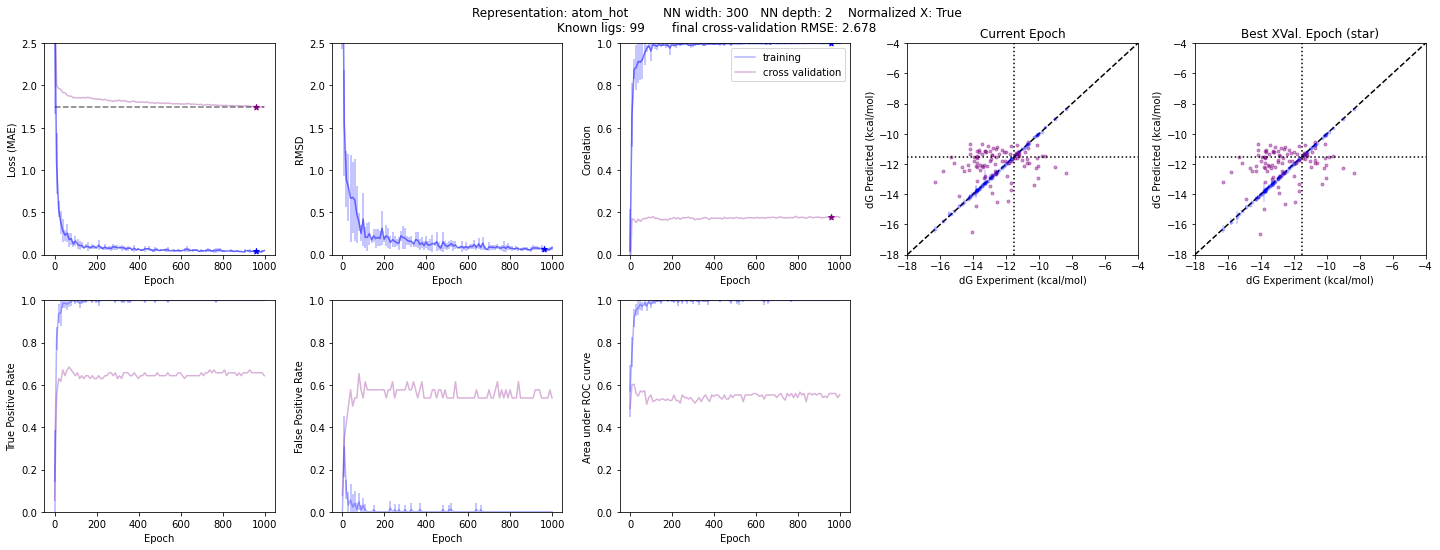

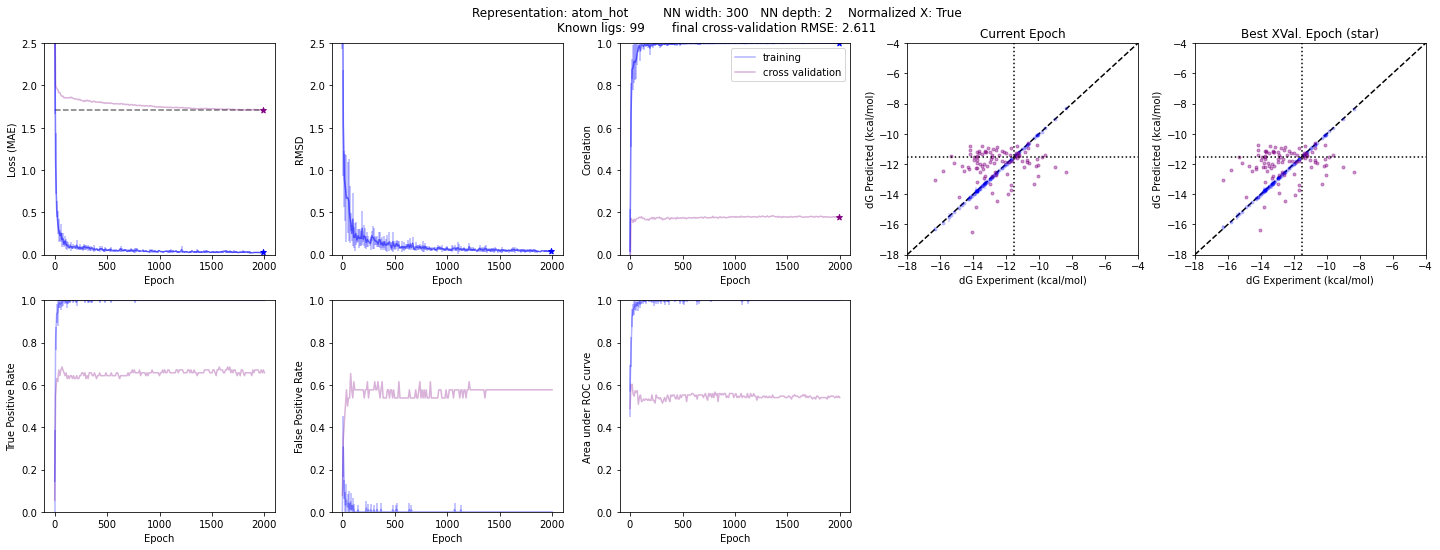

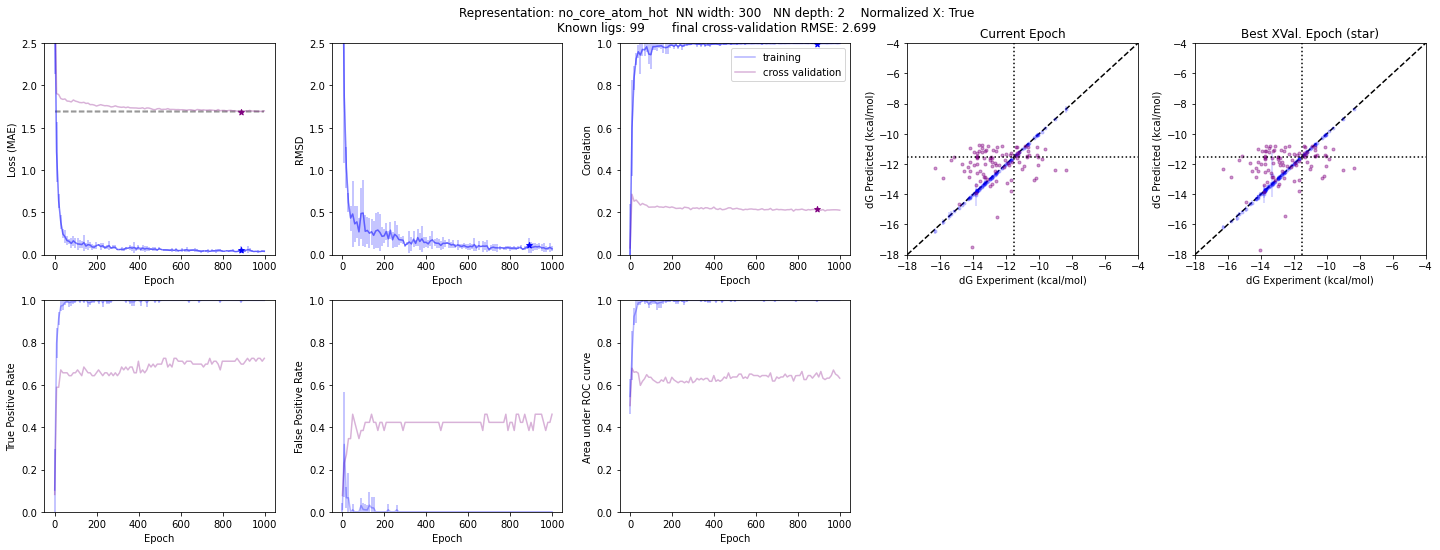

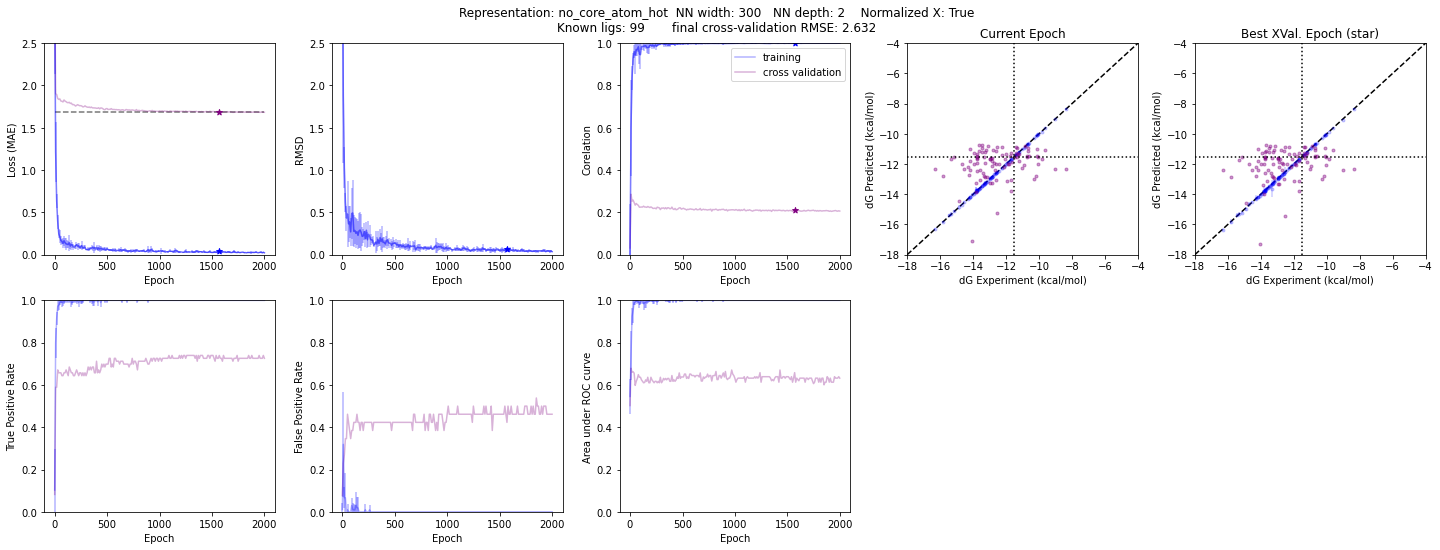

In [203]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/local_runs/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
    jobscript_str=f"""#!/bin/bash

source ~/.ML_v2_profile

export NSLOTS=4
export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

#echo NHOSTS=$NSLOTS
#echo OMP_NUM_THREADS=$OMP_NUM_THREADS

cd {cwd}

python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/owl_trainer_w_params.py -v -f {ligands_str} > {cwd}/joblog_{job_id}.log 2>&1

"""
#     jobscript_fn=cwd+"/jobscript_{}".format(job_id)
#     with open(jobscript_fn,"w") as f:
#         f.write(jobscript_str)

#     print("Running job_id", job_id, ligands_str)
#     process = subprocess.Popen(["bash", jobscript_fn], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     outs, _ = process.communicate()
#     print()
#     print(outs.decode('utf-8'))
#     process.wait()
# #     raise()

    train_model_with_settings(ligands_str[1:], False,
                              torch.device("cpu"), #torch.device("cuda:0"),
                              True, datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0")
#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

### are best predictions actually saved?

In [119]:
sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        try:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None):
                key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
                print(key)
                print(metrics.best_pred)
                print(metrics.final_pred)
                
        except Exception:
            print(f"problem with {fn}")

100%|██████████| 16/16 [00:00<00:00, 314.04it/s]

MDenerg_long_cut_binned_hlw10
(array([-10.490814, -12.656161, -12.411876, ..., -10.330019, -10.997091,
       -12.574282], dtype=float32), array([0.512099  , 0.7618145 , 0.6098956 , ..., 0.35641763, 0.41971055,
       0.9513244 ], dtype=float32))
(array([-11.530718, -13.493357, -11.045378, ..., -11.119662, -11.617006,
       -13.007405], dtype=float32), array([0.36092475, 0.12253498, 0.6917206 , ..., 0.44073018, 0.5861734 ,
       0.6422781 ], dtype=float32))
MDenerg_binned_hlw10
(array([-12.614986, -11.998159, -12.916148, ..., -11.329644, -11.729085,
       -11.413864], dtype=float32), array([0.5616955 , 0.4489415 , 0.3075975 , ..., 0.36487785, 0.286143  ,
       0.52182776], dtype=float32))
(array([-12.617155, -11.994013, -12.893374, ..., -11.337623, -11.707504,
       -11.396622], dtype=float32), array([0.5780472 , 0.4374137 , 0.31618607, ..., 0.35071003, 0.28127486,
       0.5176427 ], dtype=float32))
MDenerg_long_cut_hlw10
(array([-11.0482235, -13.354837 , -10.040269 , ..., -10.78

# submit to owl or moa

In [84]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search/jobscripts/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
    jobscript_str=f"""#!/bin/bash
    
#$ -S /bin/bash
#$ -pe openmp_fast 1
#$ -q *
#$ -N pytorch_GPU_worker_{job_id}
#$ -M ykhalak@gwdg.de
#$ -m n
#$ -l h_rt=3:00:00
#$ -wd {cwd}

#SBATCH --job-name=pytorch_SLURM_GPU_worker_{job_id}
#SBATCH --get-user-env
#SBATCH --gres=gpu:1              # number of GPUs requested
#SBATCH --ntasks=1                # Number of MPI process
#SBATCH --cpus-per-task=1         # CPU cores per MPI process
#SBATCH -p p24,p20,p16,p10,p08,p06    # partitions to use
#SBATCH -t 3:00:0                 # hours:min:sec
#SBATCH --chdir={cwd}
#SBATCH -e repr_scan_{job_id}-%j.err
#SBATCH -o repr_scan_{job_id}-%j.out

if [ -n "$NHOSTS" ]; then
    echo "Env. variable NHOSTS found, assuming we are using SGE."
    module load shared                           # access to modules in /cm/shared
else
    echo "Env. variable NHOSTS not set, assuming we are using SLURM."
    export NHOSTS=$SLURM_JOB_NUM_NODES
    export NSLOTS=$SLURM_CPUS_PER_TASK
fi

export OMP_NUM_THREADS=$NSLOTS
export MKL_NUM_THREADS=$NSLOTS

source ~/.ML_v2_profile

cp /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/modular_repr_cache.tar.gz $TMPDIR/.
cd $TMPDIR
tar -zxf modular_repr_cache.tar.gz
cd {cwd}

python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/owl_trainer_w_params.py -v -f {ligands_str} --datafolder $TMPDIR

"""
    jobscript_fn=cwd+"/jobscript_{}".format(job_id)
    with open(jobscript_fn,"w") as f:
        f.write(jobscript_str)

    global cmd_str, cmd_str_SLURM
    cmd_str+=" qsub {};".format(jobscript_fn)
    cmd_str_SLURM+=" sbatch {};".format(jobscript_fn)

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)
    
#raise()

print("Submitting.")
ssh_cmd_arr=["ssh", "owl", cmd_str]
# ssh_cmd_arr=["ssh", "moa1", cmd_str_SLURM]
process = subprocess.Popen(ssh_cmd_arr, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
outs, _ = process.communicate()
process.wait()
print('== subprocess exited with rc =', process.returncode)
print(outs.decode('utf-8'))
print("Done.")

100%|██████████| 16/16 [00:01<00:00, 12.14it/s]

previously_done: 2 	 out of: 16


settings left: 14 	 # workers: 14 	 # settings/worker: 1
Submitting.
== subprocess exited with rc = 0
Your job 6748684 ("pytorch_GPU_worker_0") has been submitted
Your job 6748685 ("pytorch_GPU_worker_1") has been submitted
Your job 6748686 ("pytorch_GPU_worker_2") has been submitted
Your job 6748687 ("pytorch_GPU_worker_3") has been submitted
Your job 6748688 ("pytorch_GPU_worker_4") has been submitted
Your job 6748689 ("pytorch_GPU_worker_5") has been submitted
Your job 6748690 ("pytorch_GPU_worker_6") has been submitted
Your job 6748691 ("pytorch_GPU_worker_7") has been submitted
Your job 6748692 ("pytorch_GPU_worker_8") has been submitted
Your job 6748693 ("pytorch_GPU_worker_9") has been submitted
Your job 6748694 ("pytorch_GPU_worker_10") has been submitted
Your job 6748695 ("pytorch_GPU_worker_11") has been submitted
Your job 6748696 ("pytorch_GPU_worker_12") has been submitted
Your job 6748697 ("pytorch_GPU_worker_13") has been submitted

Done.


# Find the ddG values of the validation ligands

### which ones are the validation ligs?

In [9]:
from rdkit import Chem
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

core_smiles="c7(C)nc8ccccc8n8c(c6c(Cl)[cH][cH][cH][cH]6)nnc78"
core=Chem.MolFromSmiles(core_smiles)

# find validation and non-validation ligands
training_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG//aligned_w_pmx_library_new_structures_similar2xrays.pickle"
with open(training_databse_fn, 'rb') as f:
    expt_ligs = pickle.load(f)
expt_ligs=[l for l in expt_ligs if not("<" in l.GetProp("[Q] hPDE2_pIC50") or ">" in l.GetProp("[Q] hPDE2_pIC50"))]

with suppress_stdout_stderr():
    res,unmatched = rdRGD.RGroupDecompose([core], expt_ligs, asSmiles=True)# print(unmatched)
matched_expt_ligs=[expt_ligs[i] for i in range(len(expt_ligs)) if not i in unmatched]

#filter out H's as R-groups
validation_ligs=[]
for i,l in enumerate(tqdm(res)):
    new_l={}
    for rg in l:
        if rg=='Core':
            continue;
        if l[rg][:3]!='[H]':
            new_l[rg]=l[rg]
    if(len(new_l)==1):
        validation_ligs.append(matched_expt_ligs[i])
print(f"found {len(validation_ligs)} validation ligands")

del expt_ligs, matched_expt_ligs
_=gc.collect()

100%|██████████| 136/136 [00:00<00:00, 253409.75it/s]

found 69 validation ligands


In [11]:
from rdkit.Chem import rdmolops
validation_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in validation_ligs]

validation_ids_in_set4f=[]
validation_ids_in_validation_subset=[]
unmeasured_ids_in_set4f=[]
measured_ids_in_set4f=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in validation_smiles):
        validation_ids_in_set4f.append(i)
        j=validation_smiles.index(smi)
        validation_ids_in_validation_subset.append(j)
    elif(not lig.HasProp('dG')):
        unmeasured_ids_in_set4f.append(i)
    else:
        measured_ids_in_set4f.append(i)
        
validation_ids_in_set4f=np.array(validation_ids_in_set4f)
validation_ids_in_validation_subset=np.array(validation_ids_in_validation_subset)
unmeasured_ids_in_set4f=np.array(unmeasured_ids_in_set4f)
measured_ids_in_set4f=np.array(measured_ids_in_set4f)

print(f"found {len(validation_ids_in_set4f)} validation ligands")
print(f"found {len(unmeasured_ids_in_set4f)} unmeasured ligands")
print(f"found {len(measured_ids_in_set4f)} measured ligands")

100%|██████████| 34114/34114 [00:11<00:00, 2862.53it/s]

found 55 validation ligands
found 33960 unmeasured ligands
found 99 measured ligands


### validation ligs experimental values

In [12]:
RT=0.001985875*300 #kcal/mol
validation_dGs=-RT*(np.array([float(validation_ligs[j].GetProp('[V] hPDE2_pIC50')) for j in validation_ids_in_validation_subset ]))*np.log(10) #kcal/mol
print(validation_dGs)

[-12.63422137 -11.94832445 -12.70281106 -12.09922177 -11.72883743
 -11.13896607 -11.75627331 -11.93460651 -11.60537598 -11.35845309
 -11.33101721 -10.933197   -11.31729927 -11.27614546 -10.61768441
 -10.08268481 -11.30358134 -10.80973555 -10.90576112 -13.29268242
 -13.16922097 -12.74396488 -12.33242672 -12.62050343 -12.07178589
 -12.67537519 -11.94832445 -11.90717063 -11.85229888 -10.56281266
 -11.92088857 -11.83858094 -11.1115302  -11.19383783 -10.87832524
 -11.39960691 -11.26242752 -11.24870958 -11.38588897 -11.34473515
 -10.78229967  -9.93178748 -11.33101721 -10.57653059 -11.08409432
 -11.53678629 -11.15268401 -10.48050503 -11.0429405  -10.91947906
 -10.82345349 -10.54909472 -11.45447866 -12.16781146 -11.30358134]


# what has the best XVal RMSE?

100%|██████████| 30/30 [00:00<00:00, 44.74it/s]


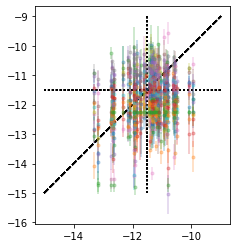

In [19]:
from utils import *
high_binder_cutoff=-5*np.log(10)



traning_RMSE={}
XVals_RMSE={}
XVals_Cor={}
XVals_KT={}
XVals_TPR={}

Val_RMSE={}
Val_Cor={}
Val_KT={}
Val_TPR={}


sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
# old_settings_folder=folder+"/meta_param_search/~settings/"
# sfiles = next(os.walk(old_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
#     settings_fname=old_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception as e:
            print(f"problem with {settings_fname}")
            raise(e)
        if(metrics is not None):
            if(settings_loaded[5]!=10):
                continue
#                 key=settings_loaded[1]
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            bi=np.argmin(metrics.loss_XVal)
            #bi=-1

            XVals_RMSE[key]=metrics.RMSD_XVal[bi]
            traning_RMSE[key]=metrics.RMSD_Train[bi]
            XVals_Cor[key]=metrics.Cor_XVal[bi]
            XVals_KT[key]=metrics.kendalltau_XVal[bi]
            XVals_TPR[key]=metrics.TP_XVal[bi]

            # Find predictions for validation ligands
            val_lig_P = metrics.best_pred[0][validation_ids_in_set4f]
            val_lig_uncert = metrics.best_pred[1][validation_ids_in_set4f]
            
            diag = np.linspace(-15,-9, 10)
            plt.plot(diag, diag, '--k', zorder=0)
            plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.errorbar(validation_dGs, val_lig_P, yerr=val_lig_uncert, marker=".", ls='', alpha=0.3)
            plt.gca().set_aspect('equal', 'box')
            
            # compute metrics for validation ligands
            se = np.square(validation_dGs-val_lig_P)
            Val_RMSE[key] = np.sqrt(np.mean(se))
            Val_Cor[key] = np.corrcoef(validation_dGs, val_lig_P)[0,1]
            Val_KT[key] = sp.stats.kendalltau(validation_dGs, val_lig_P)[0]
            _,Val_TPR[key],_ = get_FPR_TPR_AUC(validation_dGs, val_lig_P, high_binder_cutoff)
#             raise()



In [20]:
sorted_scan=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
#print(sorted_scan)
#print(list(sorted_scan.keys())[0])
#print(sorted_scan[list(sorted_scan.keys())[0]])

sorted_keys=list(sorted_scan.keys())
#print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
#for i in range(min(10,len(sorted_scan))):
for i in range(len(sorted_scan)):
    key=sorted_keys[i]
    #if('hlw10' in key):
    #print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")

             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 
no_core_atom_hot_surf_hlw10             	1.9888		0.2204		0.1666		0.6301
2D_3D_hlw10                             	2.0410		0.3322		0.2635		0.6575
MDenerg_hlw10                           	2.0472		0.0725		0.0235		0.7123
MDenerg_binned_hlw10                    	2.1053		-0.1012		-0.0544		0.7123
no_core_MDenerg_long_cut_binned_hlw10   	2.1616		0.0893		0.0676		0.6986
no_core_MDenerg_binned_hlw10            	2.1831		0.2773		0.1884		0.7397
no_core_MDenerg_long_cut_hlw10          	2.2091		0.1763		0.1010		0.6986
atom_hot_surf_hlw10                     	2.2222		-0.0764		-0.0730		0.6027
atom_hot_hlw10                          	2.3004		0.0137		0.0219		0.4521
MDenerg_long_cut_hlw10                  	2.3316		0.1730		0.2091		0.8219
MDenerg_long_cut_binned_hlw10           	2.4592		-0.0406		-0.0029		0.7123
no_core_atom_hot_hlw10                  	2.8877		-0.0501		-0.0816		0.3836
no_core_MDenerg_hlw10                   	2

In [ ]:
# replace nans with high numbers


## rank by the 4 indicators

In [21]:
sorted_RMSE=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
sorted_Cor= dict(sorted(XVals_Cor.items(), key=lambda item: item[1]))
sorted_KT=  dict(sorted(XVals_KT.items(), key=lambda item: item[1]))
sorted_TPR= dict(sorted(XVals_TPR.items(), key=lambda item: item[1]))

#RMSE
# rank_RMSE={}
# keys=list(sorted_RMSE.keys())
# start_key=keys[0]
# cur_rank=0
# for i in range(len(sorted_RMSE)):
#     key=keys[i]
#     dif=abs(XVals_RMSE[key]-XVals_RMSE[start_key])
#     err=np.sqrt(traning_RMSE[key]**2+traning_RMSE[start_key]**2)
#     if(dif>err):
#         #new rank
#         cur_rank+=1
#         start_key=key
#     rank_RMSE[key]=cur_rank

from sklearn.cluster import KMeans
nranks=5
#def rank_by_kmeans(d, nranks=10):
def rank_by_kmeans(d, nranks=nranks):
    X = np.array([[v[1]] for v in d.items()])
    kmeans = KMeans(n_clusters=nranks, random_state=0).fit(X)
    sorted_cl_ids=np.argsort(kmeans.cluster_centers_.flatten())
    #print(kmeans.cluster_centers_[sorted_cl_ids])
    rank_from_cl_id={}
    for i,j in enumerate(sorted_cl_ids):
        rank_from_cl_id[j]=i
    
    ret={}
    for i,key in enumerate(d.keys()):
        ret[key]=rank_from_cl_id[kmeans.labels_[i]]
    return(ret)

rank_RMSE=rank_by_kmeans(sorted_RMSE)
rank_Cor=rank_by_kmeans(sorted_Cor)
rank_KT=rank_by_kmeans(sorted_KT)
rank_TPR=rank_by_kmeans(sorted_TPR)


rank={}
for key in rank_RMSE.keys():
    rank[key]=rank_RMSE[key]+(nranks-1-rank_Cor[key])+(nranks-1-rank_KT[key])+(nranks-1-rank_TPR[key])

sorted_rank= dict(sorted(rank.items(), key=lambda item: item[1]))
keys=list(sorted_rank.keys())

#print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'RANK':^4}\t{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}\t|\t{'Val RMSE':^10}\t{'Val Cor':^10}\t{'Val Ken.-t':^10}\t{'Val TPR':^10}")
for i in range(len(sorted_RMSE)):
    key=keys[i]
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    #print(f"{rank[key]:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    r=rank[key]
    print(f"{r:4}\t{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}\t\t"+
          f"|\t{Val_RMSE[key]:.4f}\t\t{Val_Cor[key]:.4f}\t\t{Val_KT[key]:.4f}\t\t{Val_TPR[key]:.4f}")

RANK	             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 	|	 Val RMSE 	 Val Cor  	Val Ken.-t	 Val TPR  
   2	2D_3D_hlw10                             	2.0410		0.3322		0.2635		0.6575		|	0.8727		0.1499		0.0809		0.4545
   3	no_core_MDenerg_binned_hlw10            	2.1831		0.2773		0.1884		0.7397		|	0.8381		0.3730		0.1901		0.8636
   4	no_core_atom_hot_surf_hlw10             	1.9888		0.2204		0.1666		0.6301		|	1.2008		0.4345		0.3285		0.8182
   4	MDenerg_long_cut_hlw10                  	2.3316		0.1730		0.2091		0.8219		|	1.2739		0.0340		-0.0580		0.4091
   5	no_core_MDenerg_long_cut_hlw10          	2.2091		0.1763		0.1010		0.6986		|	0.8607		0.3725		0.1402		0.6818
   6	MDenerg_hlw10                           	2.0472		0.0725		0.0235		0.7123		|	1.1998		0.1203		0.0526		0.9091
   6	no_core_MDenerg_long_cut_binned_hlw10   	2.1616		0.0893		0.0676		0.6986		|	0.9976		0.1692		0.0688		0.8182
   6	no_core_PLEC_filtered_hlw10             	3.0217		0.1447		0.0881		0.8082		|	1.276

# Select step_1 ligands
Use hlw=10, depth=2. Top 5 representations are:
<pre>
RANK	             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 	|	 Val RMSE 	 Val Cor  	Val Ken.-t	 Val TPR  
   2	2D_3D_hlw10                             	2.0410		0.3322		0.2635		0.6575		|	0.8727		0.1499		0.0809		0.4545
   3	no_core_MDenerg_binned_hlw10            	2.1831		0.2773		0.1884		0.7397		|	0.8381		0.3730		0.1901		0.8636
   4	no_core_atom_hot_surf_hlw10             	1.9888		0.2204		0.1666		0.6301		|	1.2008		0.4345		0.3285		0.8182
   4	MDenerg_long_cut_hlw10                  	2.3316		0.1730		0.2091		0.8219		|	1.2739		0.0340		-0.0580		0.4091
   5	no_core_MDenerg_long_cut_hlw10          	2.2091		0.1763		0.1010		0.6986		|	0.8607		0.3725		0.1402		0.6818
</pre>

In [201]:
best_keys=['2D_3D_hlw10', 'no_core_MDenerg_binned_hlw10', 'no_core_atom_hot_surf_hlw10', 'MDenerg_long_cut_hlw10', 'no_core_MDenerg_long_cut_hlw10']
#best_keys=['2D_3D_hlw10', 'no_core_MDenerg_binned_hlw10', 'no_core_atom_hot_surf_hlw10', 'MDenerg_long_cut_hlw10', 'MDenerg_hlw10']
print(best_keys)

['2D_3D_hlw10', 'no_core_MDenerg_binned_hlw10', 'no_core_atom_hot_surf_hlw10', 'MDenerg_long_cut_hlw10', 'no_core_MDenerg_long_cut_hlw10']


In [202]:
sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

new_lig_ids=[]
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            if(key in best_keys):
                print(key)
                unmeasured_P = metrics.best_pred[0][unmeasured_ids_in_set4f]
                unmeasured_uncert = metrics.best_pred[1][unmeasured_ids_in_set4f]
                
                sorted_unmeasured_ids=unmeasured_ids_in_set4f[np.argsort(unmeasured_P)]
#                 print(metrics.best_pred[0][sorted_unmeasured_ids[:20]])
                selected=0
                n=0
                attempted_duplicates=0
                attempted_duplicates_by_repr=[0 for i in range(5)]
                while selected<20 and n<len(sorted_unmeasured_ids):
                    if(sorted_unmeasured_ids[n] not in new_lig_ids):
                        new_lig_ids.append(sorted_unmeasured_ids[n])
                        selected+=1
                    else:
                        attempted_duplicates+=1
                        prev_repr=int(np.floor(new_lig_ids.index(sorted_unmeasured_ids[n])/20))
                        attempted_duplicates_by_repr[prev_repr]+=1
                    n+=1
                print(len(new_lig_ids), attempted_duplicates, attempted_duplicates_by_repr)
#                 raise()


  7%|▋         | 2/30 [00:00<00:03,  7.54it/s]

MDenerg_long_cut_hlw10


NameError: name 'unmeasured_ids_in_set4f' is not defined

In [24]:
selected_ligs=[ligs_set4f[i] for i in new_lig_ids]
legends=[f"{l.GetProp('ID')}" for l in selected_ligs]

selected_RGroups=[Chem.MolFromSmiles(Chem.MolToSmiles(no_core_ligs_set4f[i])) for i in new_lig_ids]
Draw.MolsToGridImage(selected_RGroups, legends=legends,
                     subImgSize = (100,100), molsPerRow=10, maxMols=100)

NameError: name 'no_core_ligs_set4f' is not defined

In [234]:
with  open( pocket_fit_folder+"/step_1_picks.pickle", "wb" ) as f:
    pickle.dump(selected_ligs, f)

# Train on the expt ligands
to get a base-line accuracy goal

### save expt ligs as a pickles for training

In [262]:
from rdkit.Chem import PropertyMol
expt_ligs=[]
# validation_ids_in_set4f
# validation_ids_in_validation_subset
order=np.argsort(validation_ids_in_validation_subset)
for i in range(len(order)):
    lig = validation_ligs[i]
    se4f_lig_equivalent = PropertyMol.PropertyMol(ligs_set4f[validation_ids_in_set4f[order[i]]])
    se4f_lig_equivalent.SetProp('dG', str(validation_dGs[order[i]]))
    expt_ligs.append(se4f_lig_equivalent)

In [273]:
expt_db_file=f"{pocket_fit_folder}/expt_validation_ligs.pickle"
with  open( expt_db_file, "wb" ) as f:
    pickle.dump(expt_ligs, f)

In [295]:
with open(expt_db_file, 'rb') as f:
    expt_ligs = pickle.load(f)

for lig in expt_ligs:
    print(lig.GetProp('dG'))

-13.292682420694543
-13.169220974062705
-12.743964880108598
-12.702811064564651
-12.675375187535355
-12.634221371991408
-12.62050343347676
-12.332426724669139
-12.167811462493352
-12.099221769920112
-12.071785892890814
-11.948324446258978
-11.948324446258978
-11.934606507744327
-11.920888569229678
-11.90717063071503
-11.852298876656437
-11.838580938141789
-11.756273307053895
-11.728837430024598
-11.605375983392761
-11.536786290819517
-11.454478659731624
-11.39960690567303
-11.385888967158381
-11.358453090129084
-11.344735151614433
-11.331017213099786
-11.331017213099786
-11.317299274585137
-11.30358133607049
-11.30358133607049
-11.276145459041194
-11.262427520526545
-11.248709582011893
-11.1938378279533
-11.152684012409354
-11.138966073894705
-11.111530196865408
-11.08409431983611
-11.042940504292167
-10.933196996174976
-10.919479057660327
-10.90576111914568
-10.87832524211638
-10.823453488057787
-10.809735549543136
-10.78229967251384
-10.617684410338057
-10.57653059479411
-10.56281265

## prep settings pickles

In [349]:
settings_folder_train_on_expt_ligs=folder+"/meta_param_search_train_on_expt_ligs/settings/"
print(settings_folder_train_on_expt_ligs)
os.makedirs(settings_folder_train_on_expt_ligs, exist_ok=True)

/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/


In [350]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True

redo=False

block_names_full=["2D_3D", "PLEC_filtered", "MDenerg", "MDenerg_long_cut", "MDenerg_binned", "MDenerg_long_cut_binned", "atom_hot", "atom_hot_surf"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_full)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    nMDenerg_repr=0
    nah_repr=0
    ntot_repr=0
    
    if(b_2D_3D):
        for b in flags_2D:
            representation_flags[int(b)]=1
        for b in flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.MDenerg)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.MDenerg_longcut)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.MDenerg_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.MDenerg_longcut_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.atom_hot)]=1
        nah_repr+=1
        ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.atom_hot_on_vdw_surf)]=1
        nah_repr+=1
        ntot_repr+=1
        
    if(nMDenerg_repr>1 or nah_repr>1):
        continue
    if(ntot_repr>1):
        continue

    dr_name=""
#     for i in range(len(representation_flags)):
#         if representation_flags[i]:
#             dr_name+=dataBlocks(i).name+'_'
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_full[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder_train_on_expt_ligs+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

256
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/atom_hot_surf_1fc970b6e0.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/atom_hot_c16d579b85.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/MDenerg_long_cut_binned_cbaf100462.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/

In [359]:
normalize_x=True
shuffle_seed=12345678

n_Epochs=20000
#hl_w=300
hl_w=10
hl_depth=2
init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True    
use_dropout=True
shiftY=True

redo=False

block_names_no_core=["no_core_2D_3D", "no_core_PLEC_filtered", "no_core_MDenerg",
                     "no_core_MDenerg_long_cut", "no_core_MDenerg_binned",
                     "no_core_MDenerg_long_cut_binned",
                     "no_core_atom_hot", "no_core_atom_hot_surf"]
import itertools
l = [False, True]
combs=list(itertools.product(l, repeat=len(block_names_no_core)))
print(len(combs))
#raise()

for c in combs:
    b_2D_3D, b_PLEC_filt, b_MDenerg, b_MDenerg_lc, b_MDenerg_binned, b_MDenerg_lc_binned, b_ah, b_ah_vdw = c
    if np.count_nonzero(c)==0:
        continue # skip the case with no active reperesenations
        
    if(b_ah and b_ah_vdw):
        continue # skip if both atom hot forms are active

    representation_flags=[0]*len(dataBlocks)
    
    nMDenerg_repr=0
    nah_repr=0
    ntot_repr=0
    
    if(b_2D_3D):
        for b in no_core_flags_2D:
            representation_flags[int(b)]=1
        for b in no_core_flags_3D:
            representation_flags[int(b)]=1
        ntot_repr+=1
        
        #don't do no_core_2D_3D until it's fixed
        #continue
        
    if(b_PLEC_filt):
        representation_flags[int(dataBlocks.no_core_PLEC_filtered)]=1
        ntot_repr+=1
    if(b_MDenerg):
        representation_flags[int(dataBlocks.no_core_MDenerg)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_MDenerg_lc_binned):
        representation_flags[int(dataBlocks.no_core_MDenerg_longcut_binned)]=1
        nMDenerg_repr+=1
        ntot_repr+=1
    if(b_ah):
        representation_flags[int(dataBlocks.no_core_atom_hot)]=1
        nah_repr+=1
        ntot_repr+=1
    if(b_ah_vdw):
        representation_flags[int(dataBlocks.no_core_atom_hot_on_vdw_surf)]=1
        nah_repr+=1
        ntot_repr+=1
        
    if(nMDenerg_repr>1 or nah_repr>1):
        continue
    if(ntot_repr>1):
        continue

    dr_name=""
#     for i in range(len(representation_flags)):
#         if representation_flags[i]:
#             dr_name+=dataBlocks(i).name+'_'
    for i in range(len(c)):
        if c[i]:
            dr_name+=block_names_no_core[i]+'_'
    dr_name=dr_name[:-1]
    
    settings=[
        representation_flags, dr_name, normalize_x, shuffle_seed,
        n_Epochs, hl_w, hl_depth, init_learning_rate, learning_rate_decay, weight_decay,
        impfilt, X_filter,
        weighted, shiftY, use_dropout
        ]
    
    
    sha = hashlib.sha256()
    sha.update(pickle.dumps(settings))
    settings_hash=dr_name+"_"+sha.hexdigest()[:10]

    settings_fname=settings_folder_train_on_expt_ligs+f"{settings_hash}.pickle"
    if(os.path.exists(settings_fname)):
        with open(settings_fname, 'rb') as f:
            settings_loaded, metrics = pickle.load(f)
            if(metrics is not None and not redo):
                print(f"{settings_fname} is already trained.")
            else:
                print(f"{settings_fname} exists but is not trained yet.")
    else:
        pickle.dump( (settings, None), open( settings_fname, "wb" ) )

256
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/no_core_atom_hot_surf_49f5a8080f.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/no_core_atom_hot_623d69e1ca.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search_train_on_expt_ligs/settings/no_core_MDenerg_long_cut_binned_ae8dfbd01a.pickle is already trained.
/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset//prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_se

## Run the training

### load the updated function to train these

In [377]:
if 'custom_dataset_modular_with_binning' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning'])
else:
    import custom_dataset_modular_with_binning
from custom_dataset_modular_with_binning import dataBlocks, CustomMolModularDataset



if 'owl_trainer_w_params_train_on_expt' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_train_on_expt'])
else:
    import owl_trainer_w_params_train_on_expt
from owl_trainer_w_params_train_on_expt import train_model_on_expt_with_settings

In [378]:
for b in [dataBlocks.no_core_GETAWAY]:
    representation_flags=[0]*len(dataBlocks)
    representation_flags[int(b)]=1
    print(dataBlocks(int(b)).name)

    DS=CustomMolModularDataset(ligs=ligs_set4f, no_core_ligs=no_core_ligs_set4f,
                           representation_flags=representation_flags, normalize_x=False,
                           use_cache=False, use_hdf5_cache=False, use_combined_cache=False)
    
    DS.build_internal_filtered_cache()

    print("\t\t", np.any(~np.isfinite(DS.internal_filtered_cache[0])))

no_core_GETAWAY
		 True


In [379]:
# which ones have nans?
# GETAWAY_nan_X_columns = np.where(np.any(~np.isfinite(DS.internal_filtered_cache[0]), axis=0))
GETAWAY_nan_lig_indeces, GETAWAY_nan_X_columns = np.where(~np.isfinite(DS.internal_filtered_cache[0]))
GETAWAY_nan_lig_indeces=np.unique(GETAWAY_nan_lig_indeces)
GETAWAY_nan_X_columns=np.unique(GETAWAY_nan_X_columns)
print(GETAWAY_nan_lig_indeces)
print(GETAWAY_nan_X_columns)

[    2     3     4 ... 34111 34112 34113]
[119 126 165 166]


### run scan locally

100%|██████████| 16/16 [00:00<00:00, 18.42it/s]

previously_done: 15 	 out of: 16
settings left: 1 	 # workers: 1 	 # settings/worker: 1




Representation is: no_core_2D_3D


# starting ligands: 55


/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Building the internal_filtered_cache needs 544.7433624267578 MB, more than the 512.0 MB limit. SKIPPING and will read samples from HDD each time instead.
Training for 20000 epochs
	Epoch: 0	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 29	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 39	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 49	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 59	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 69	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 79	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 89	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 99	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 189	 tra

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 999. Backing up models.
	Epoch: 1009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 1219	 train_loss=nan	 XVal_RMSE=nan
	E

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 1999. Backing up models.
	Epoch: 2009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 2219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 2999. Backing up models.
	Epoch: 3009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 3219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 3999. Backing up models.
	Epoch: 4009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 4219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 4999. Backing up models.
	Epoch: 5009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 5219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 5999. Backing up models.
	Epoch: 6009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 6219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 6999. Backing up models.
	Epoch: 7009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 7219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 7999. Backing up models.
	Epoch: 8009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 8219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 8999. Backing up models.
	Epoch: 9009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 9219	 train_loss=nan	 XVal_RMSE=nan
	

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 9999. Backing up models.
	Epoch: 10009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 10219	 train_los

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 10999. Backing up models.
	Epoch: 11009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 11219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 11999. Backing up models.
	Epoch: 12009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 12219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 12999. Backing up models.
	Epoch: 13009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 13219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 13999. Backing up models.
	Epoch: 14009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 14219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 14999. Backing up models.
	Epoch: 15009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 15219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 15999. Backing up models.
	Epoch: 16009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 16219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 16999. Backing up models.
	Epoch: 17009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 17219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 17999. Backing up models.
	Epoch: 18009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 18219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 18999. Backing up models.
	Epoch: 19009	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19019	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19029	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19039	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19049	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19059	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19069	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19079	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19089	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19099	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19109	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19119	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19129	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19139	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19149	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19159	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19169	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19179	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19189	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19199	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19209	 train_loss=nan	 XVal_RMSE=nan
	Epoch: 19219	 train_lo

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Epoch 19999. Backing up models.
Training done. Saving models.
Done.


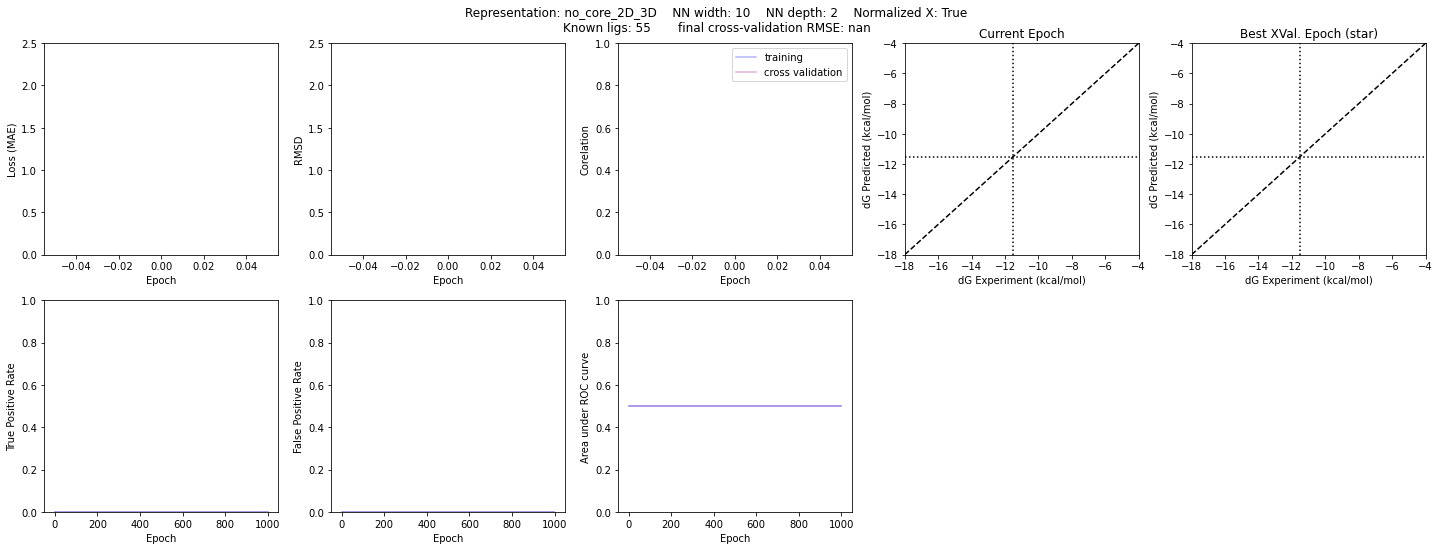

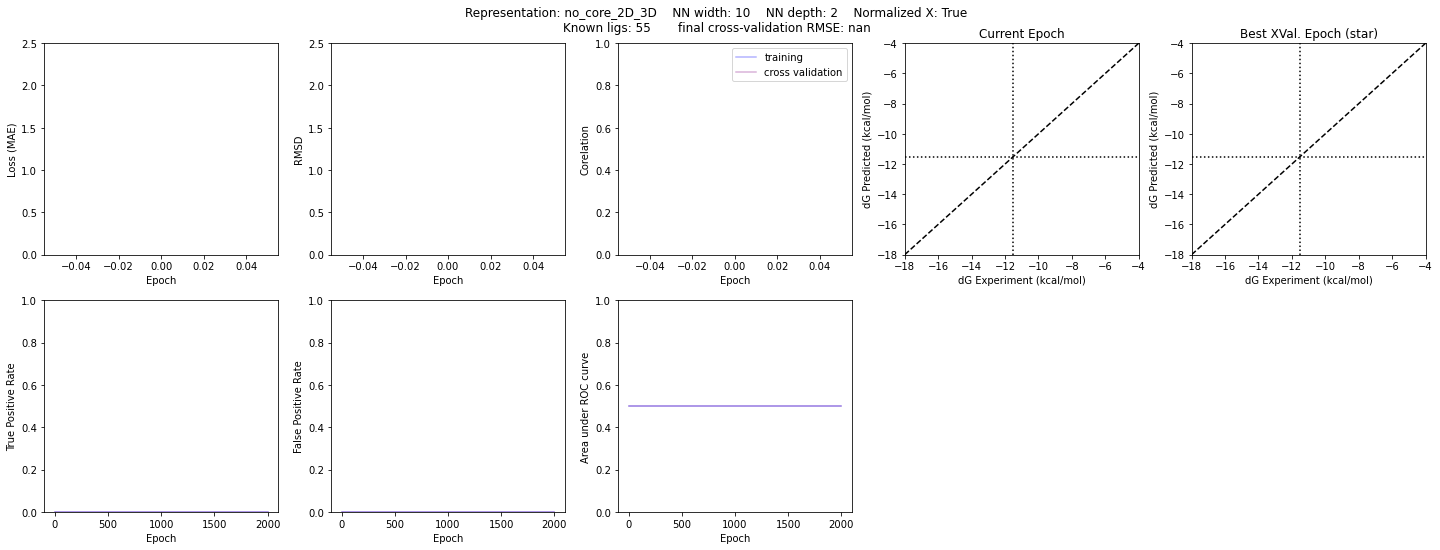

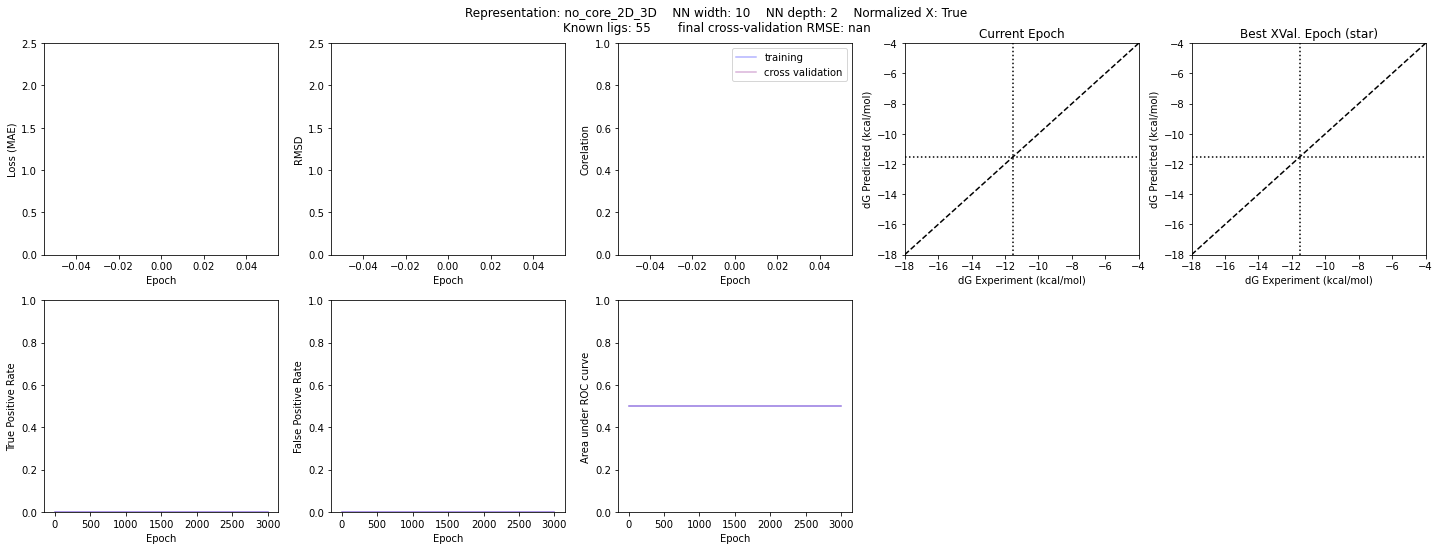

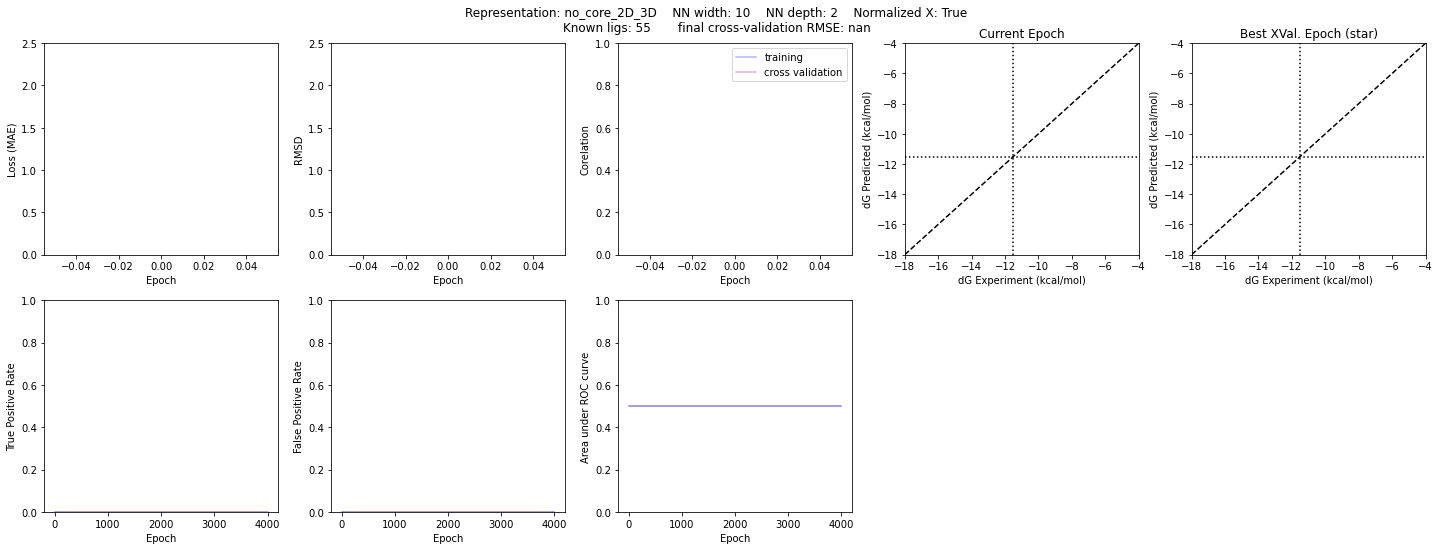

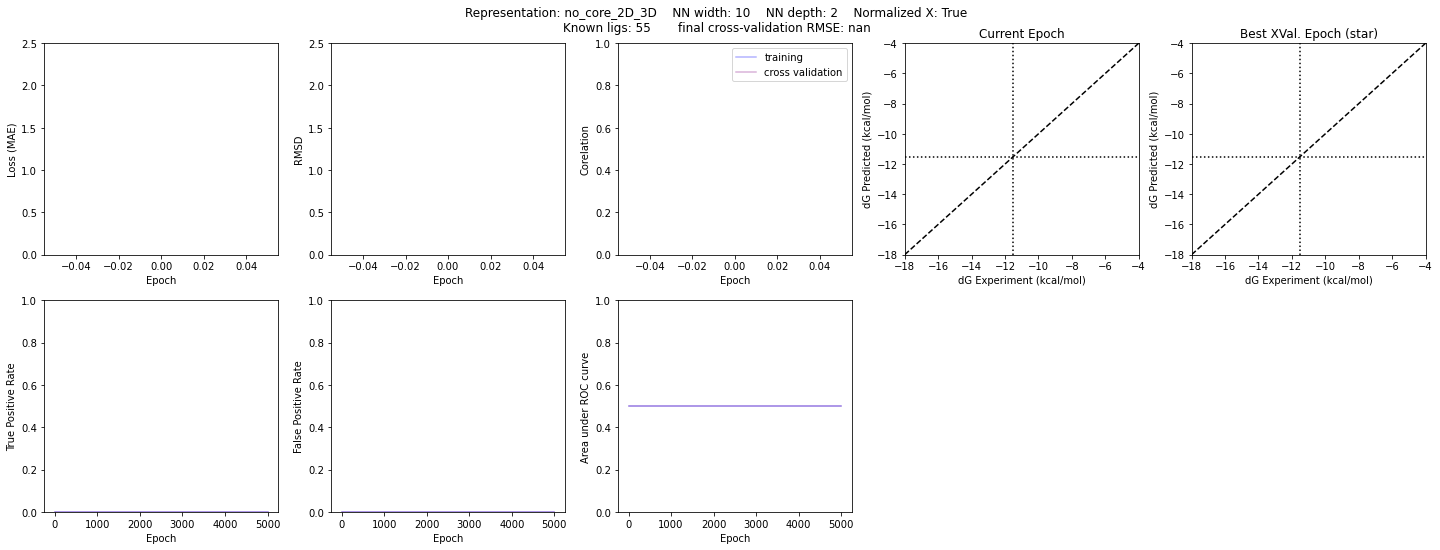

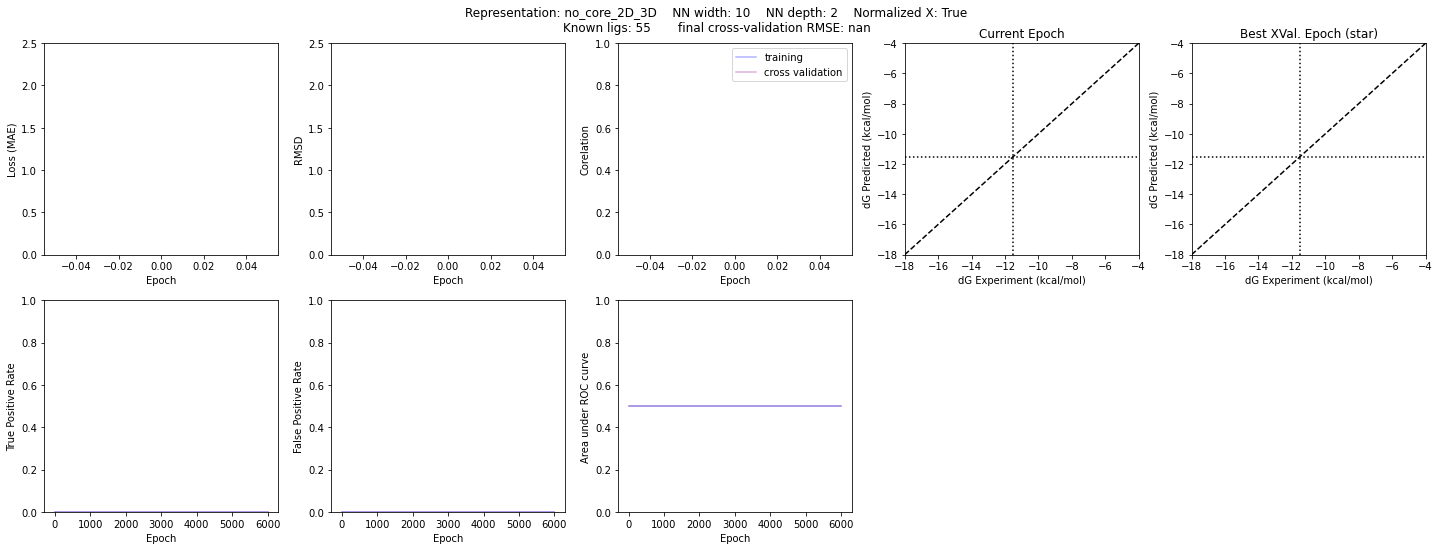

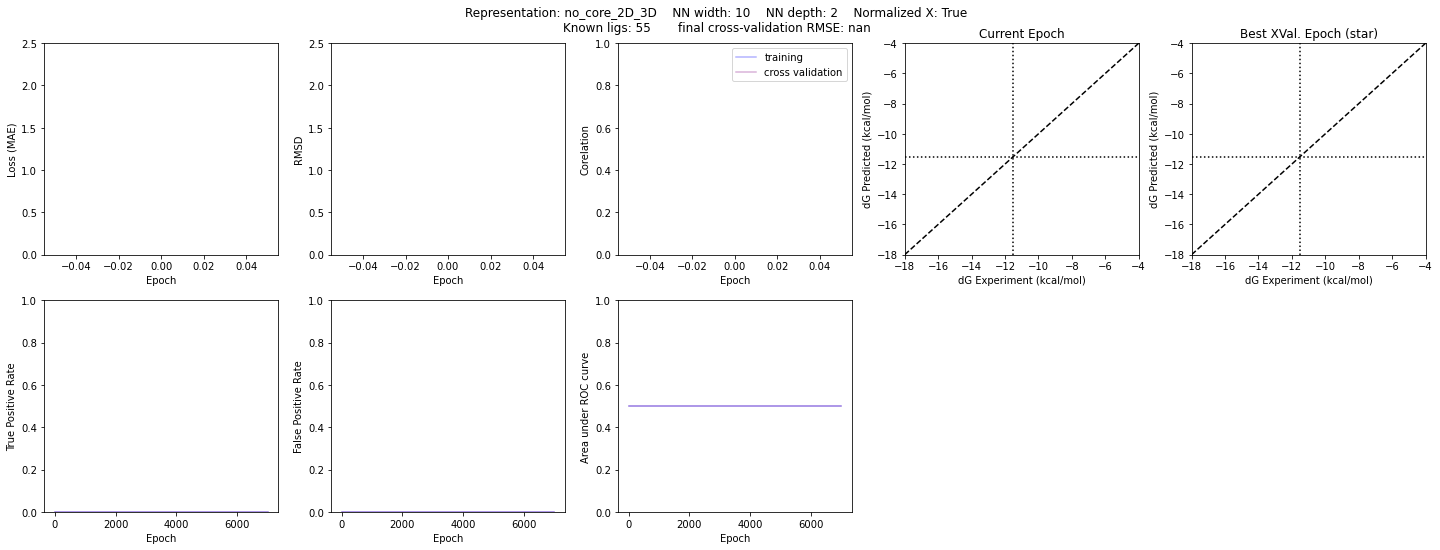

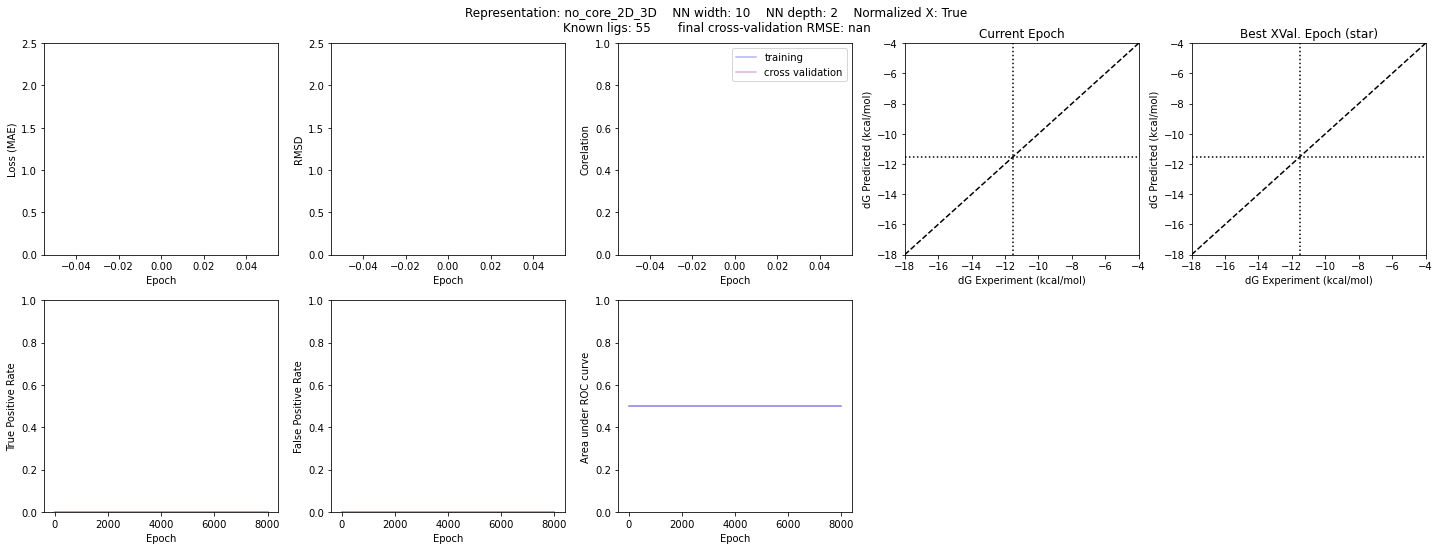

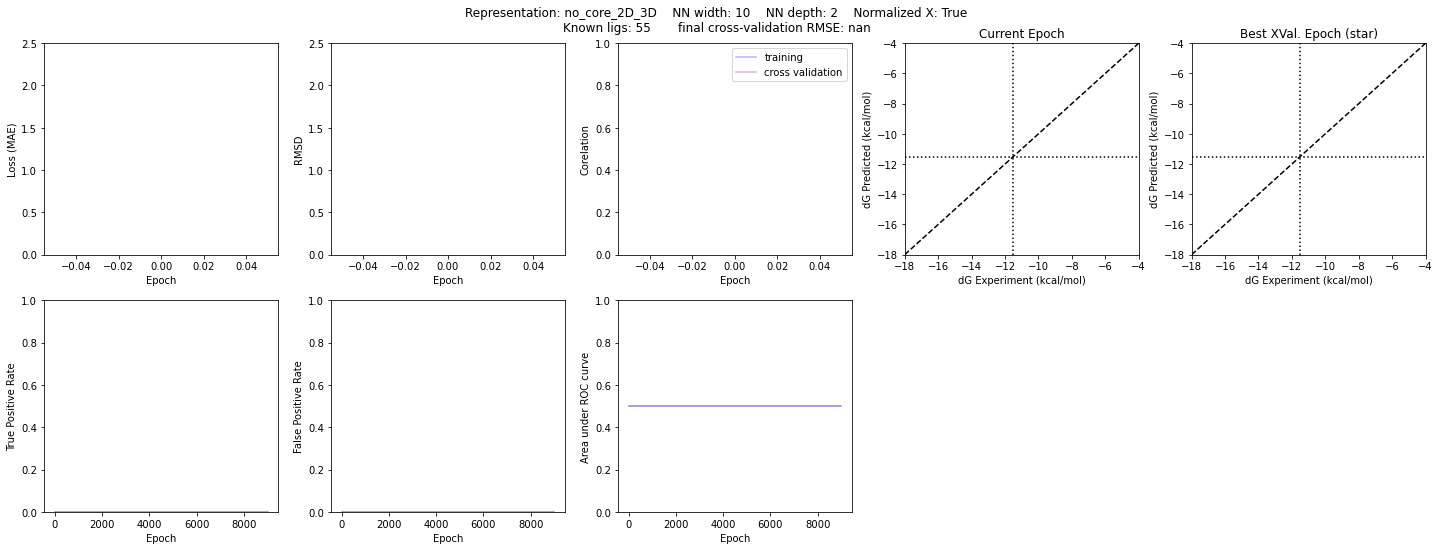

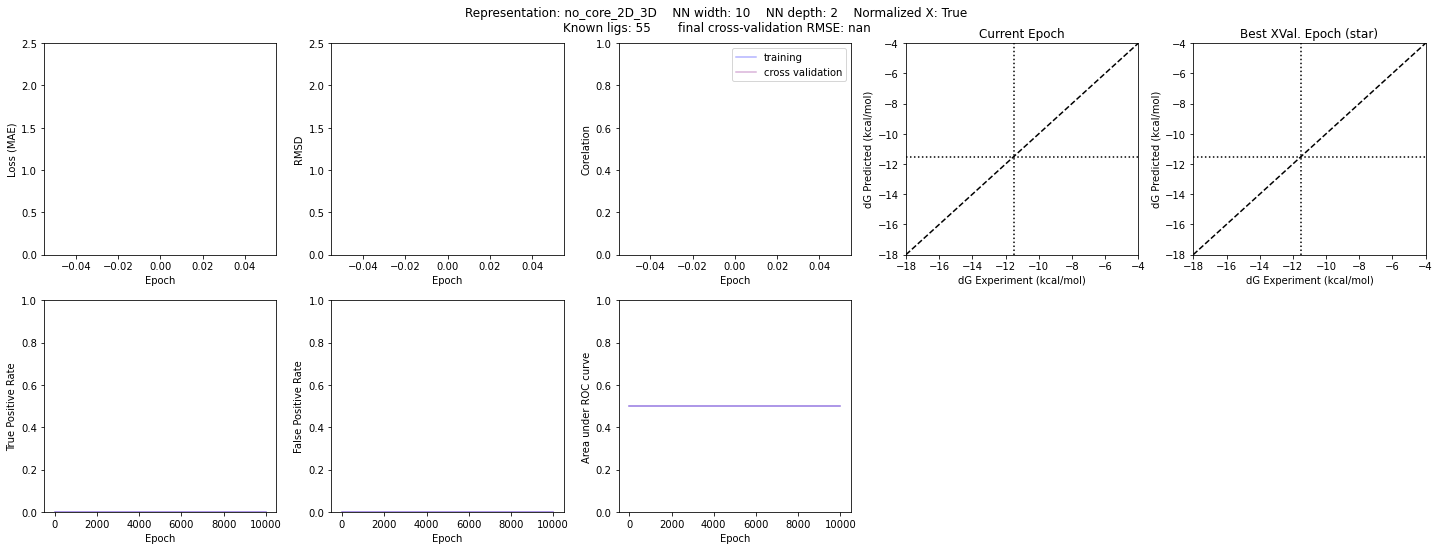

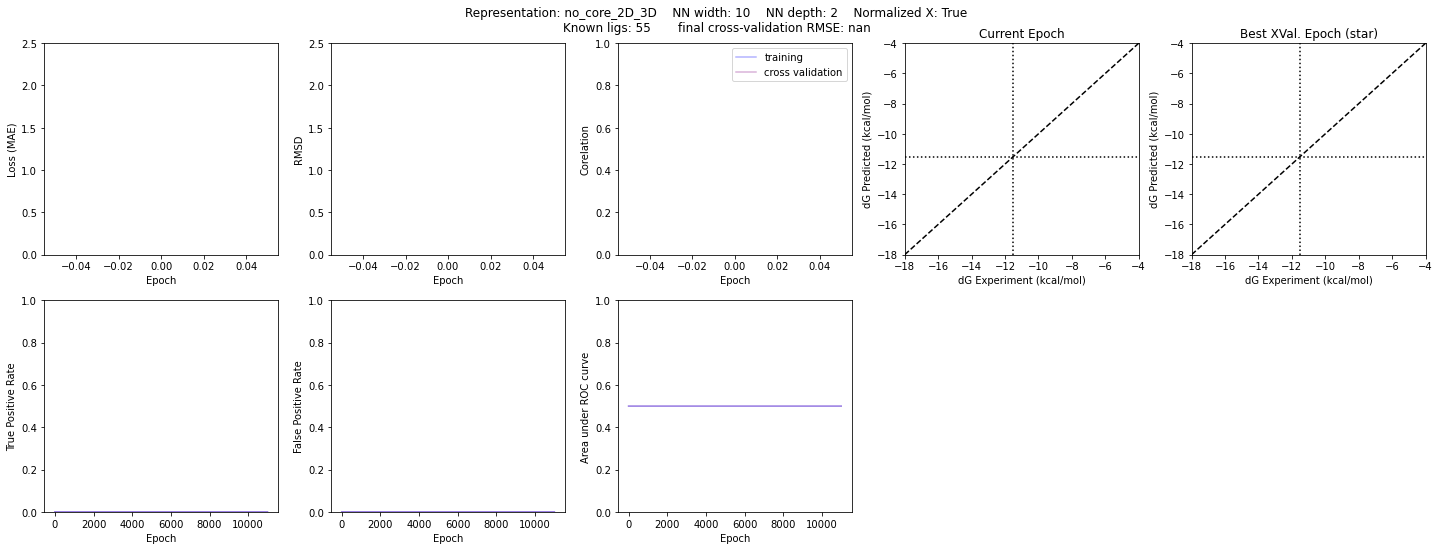

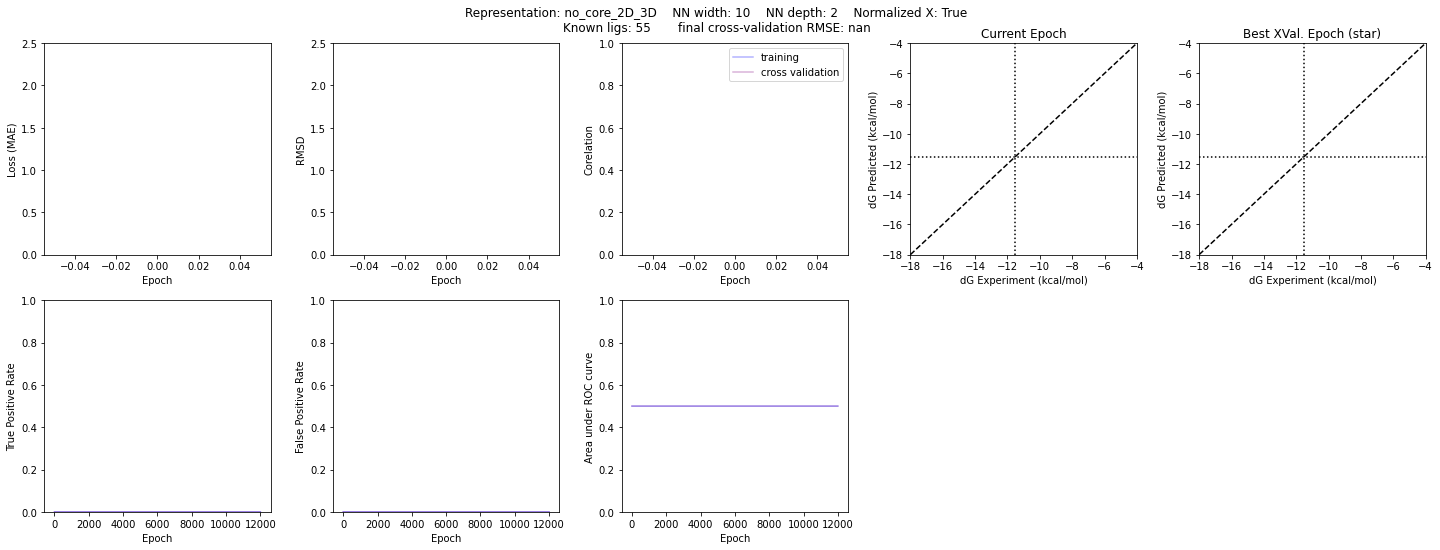

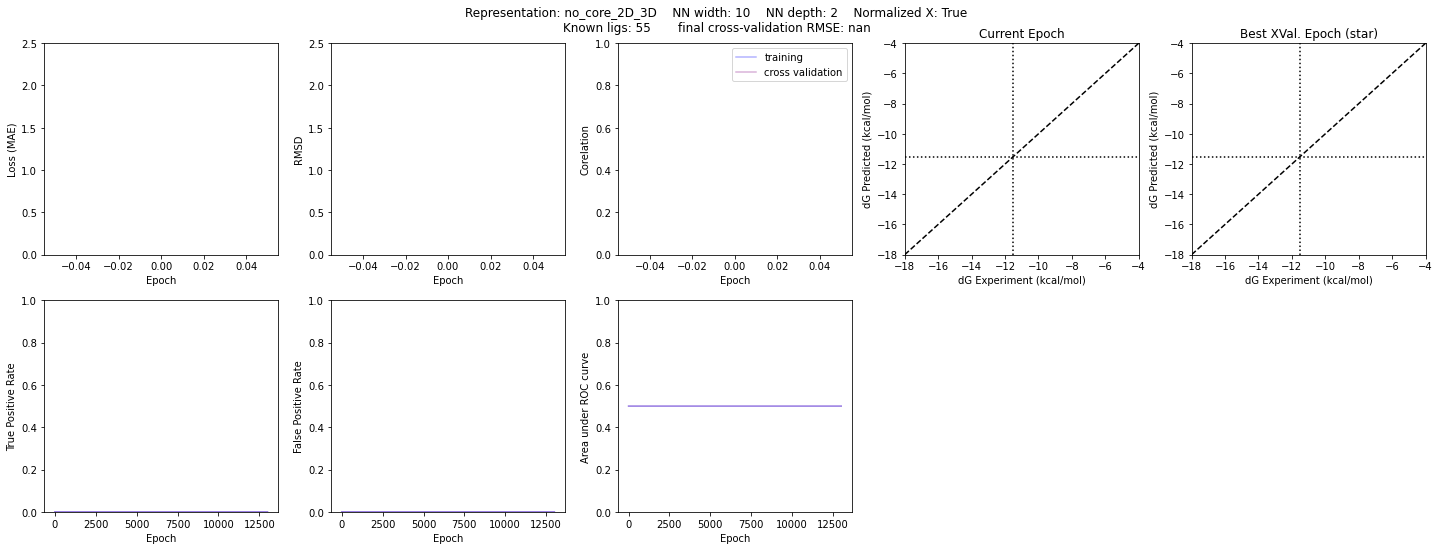

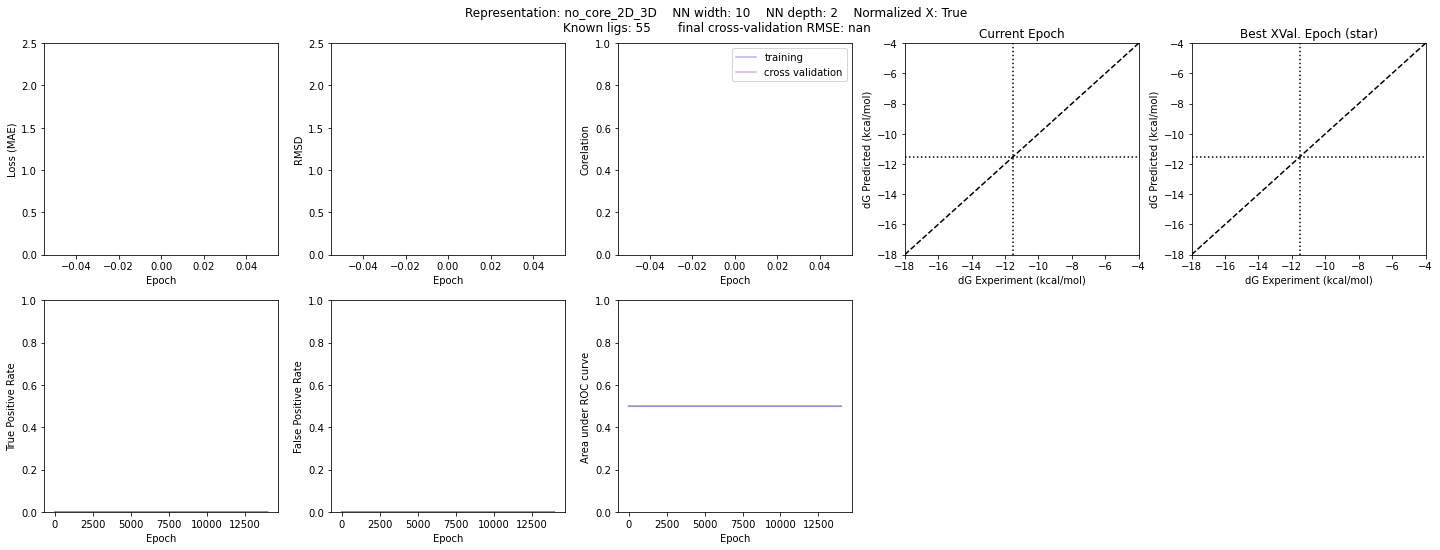

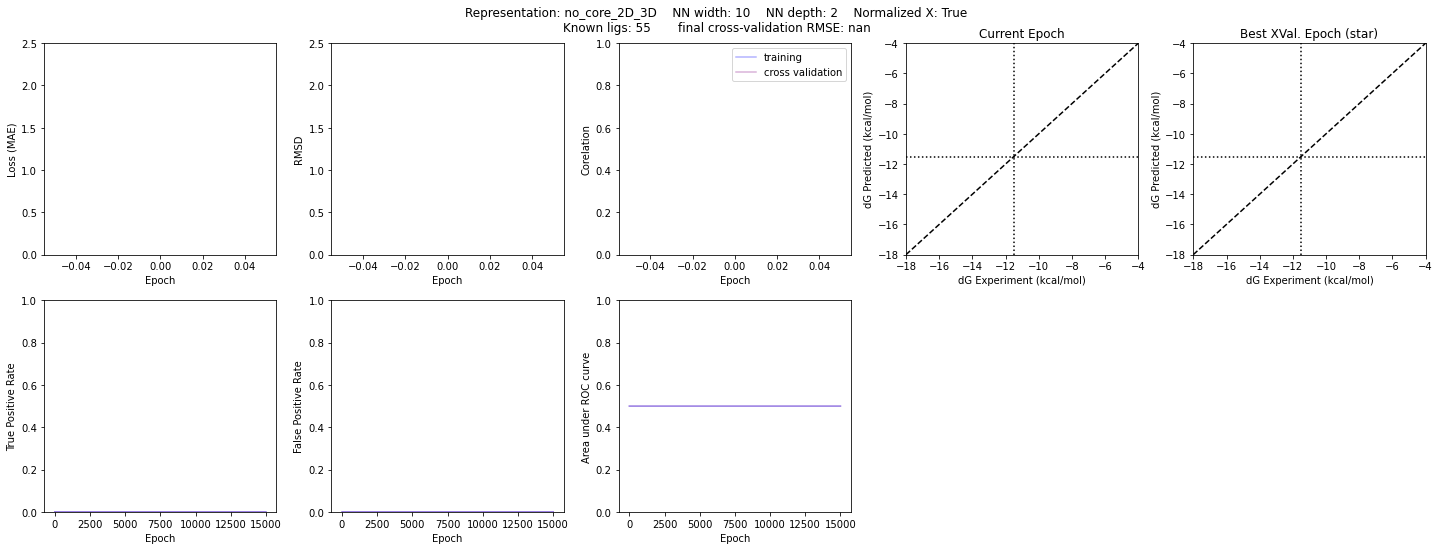

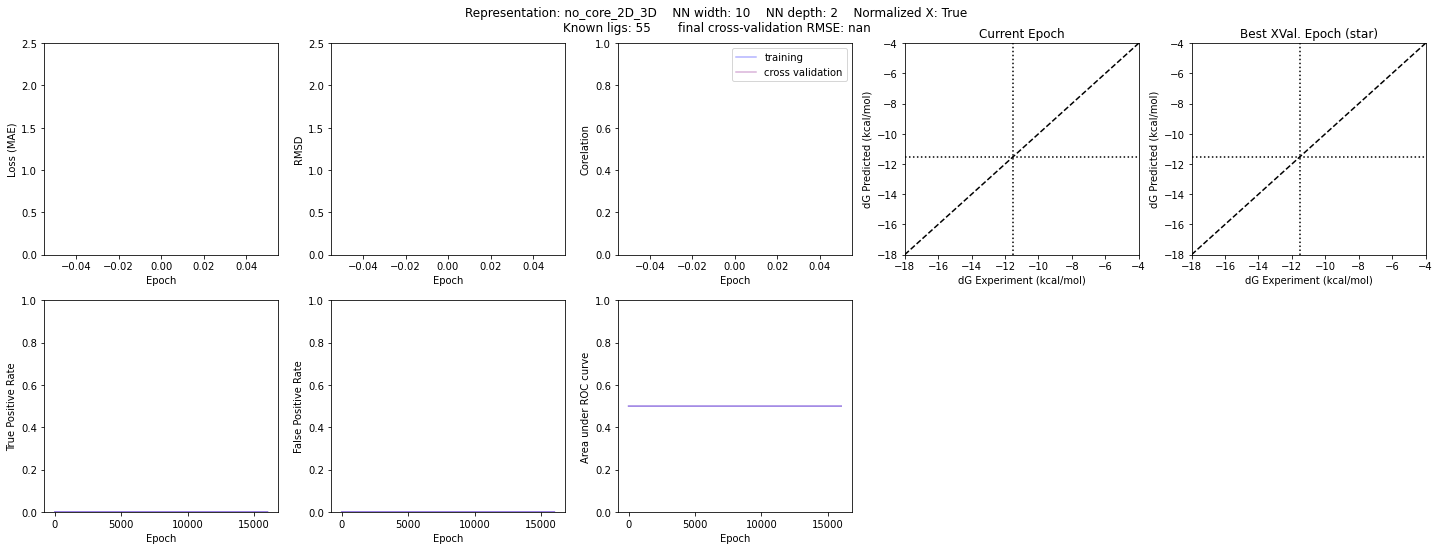

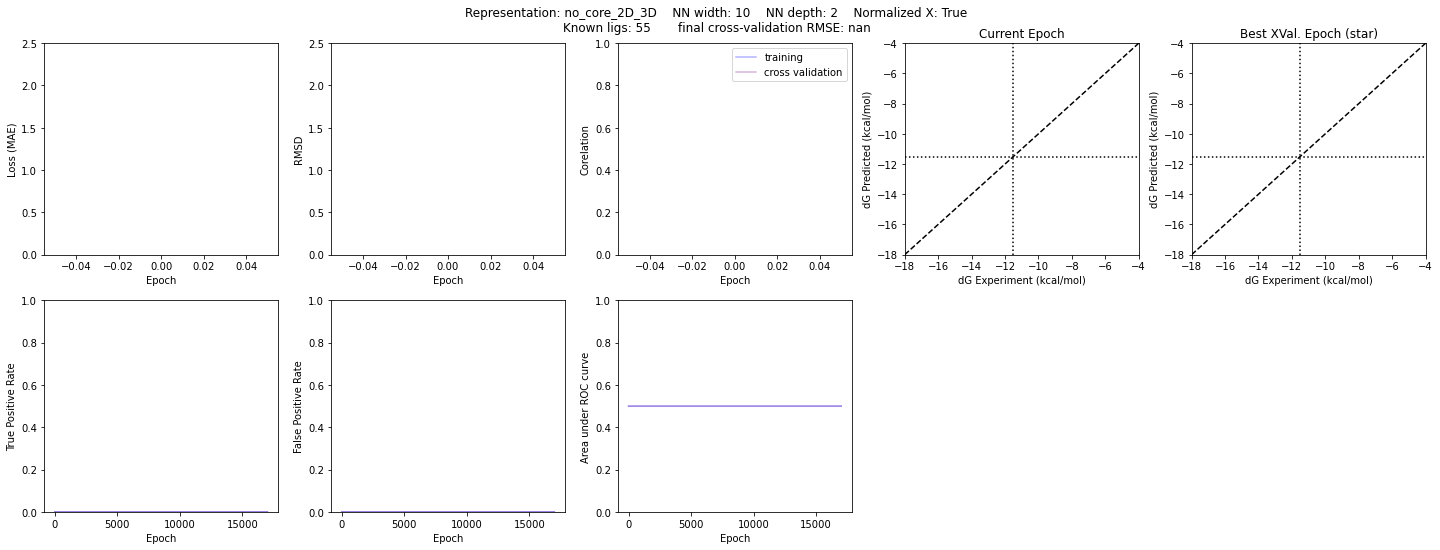

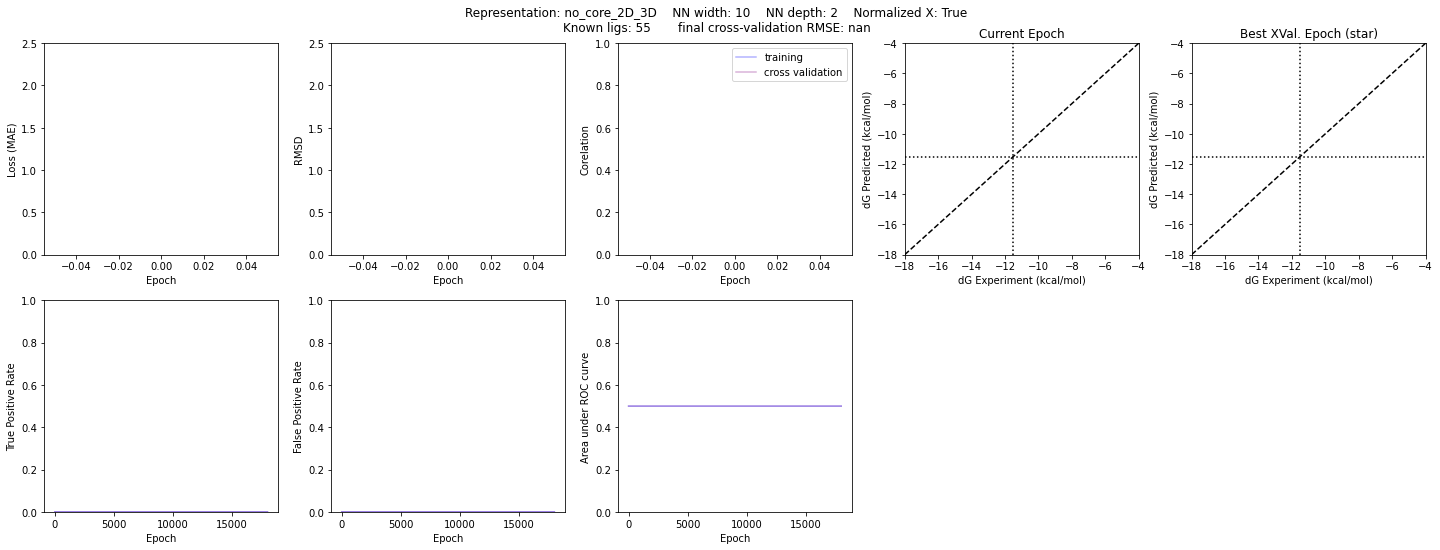

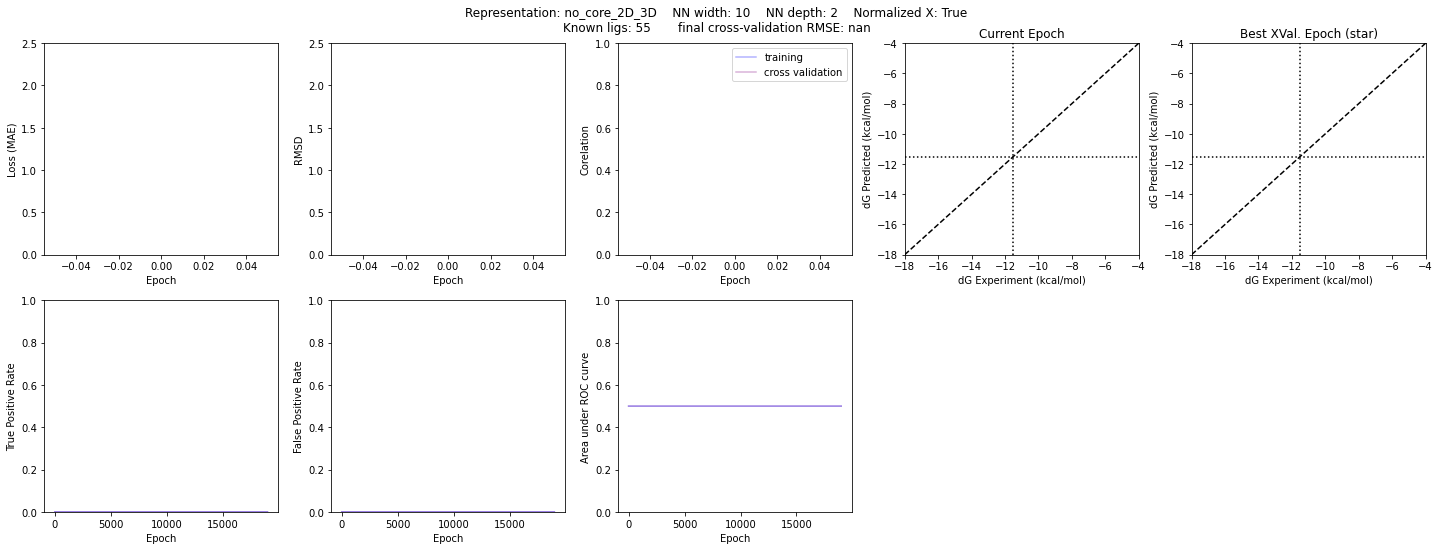

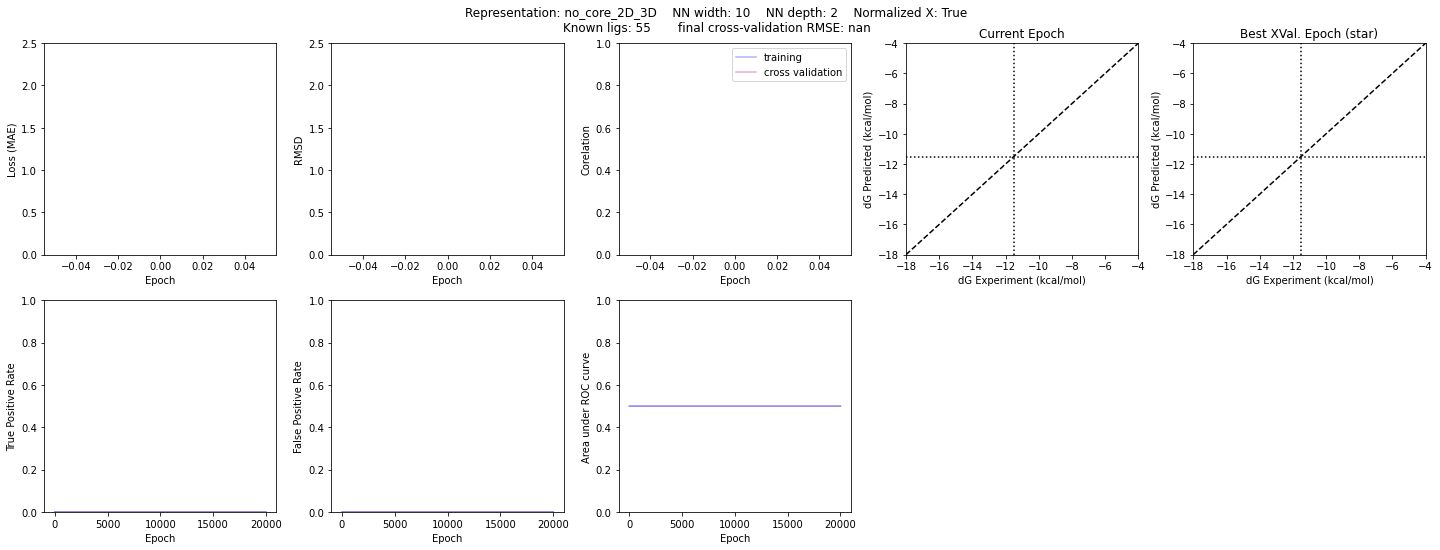

In [373]:
import queue
import threading

previously_done=0
max_debug_evals=10e8

sfiles = next(os.walk(settings_folder_train_on_expt_ligs), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory

q = queue.Queue()
for f in tqdm(sfiles):
    settings_fname=settings_folder_train_on_expt_ligs+"/"+f
    with open(settings_fname, 'rb') as f:
        settings_loaded, metrics = pickle.load(f)
        if(metrics is None):
            q.put(settings_fname)
            #print(settings_fname)
            if(q.qsize()>=max_debug_evals):
                break;
        else:
            previously_done+=1

print("previously_done:", previously_done, "\t out of:", len(sfiles), flush=True)
nleft=len(sfiles)-previously_done
nworkers=max(min(30, nleft), 1)
n_per_worker=int(np.ceil(float(nleft)/nworkers))
print("settings left:", nleft, "\t # workers:", nworkers, "\t # settings/worker:", n_per_worker)

# raise()

cwd=folder+"/meta_param_search_train_on_expt_ligs/local_runs/"
cmd_str=f"source /etc/profile; module load sge; cd {cwd};"
cmd_str_SLURM=f"source /etc/profile; cd {cwd};"

def worker(job_id):
    ligands_str=""
    for l in range(n_per_worker):
        fname = q.get()
        if fname is None:  # EOF?
            break
        ligands_str+=" "+fname
    os.makedirs(cwd, exist_ok=True)
#     jobscript_str=f"""#!/bin/bash

# source ~/.ML_v2_profile

# export NSLOTS=4
# export OMP_NUM_THREADS=$NSLOTS
# export MKL_NUM_THREADS=$NSLOTS

# #echo NHOSTS=$NSLOTS
# #echo OMP_NUM_THREADS=$OMP_NUM_THREADS

# cd {cwd}

# python /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/owl_trainer_w_params_train_on_expt.py -v -f {ligands_str} > {cwd}/joblog_{job_id}.log 2>&1

# """

#     jobscript_fn=cwd+"/jobscript_{}".format(job_id)
#     with open(jobscript_fn,"w") as f:
#         f.write(jobscript_str)

#     print("Running job_id", job_id, ligands_str)
#     process = subprocess.Popen(["bash", jobscript_fn], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     outs, _ = process.communicate()
#     print()
#     print(outs.decode('utf-8'))
#     process.wait()
# #     raise()

    train_model_on_expt_with_settings(ligands_str[1:], False,
                              torch.device("cpu"), #torch.device("cuda:0"),
                              True, datafolder="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0")
#     raise()

for job_id in range(nworkers):
    q.put(None)
    worker(job_id)

print("Done.")

## show results

 88%|████████▊ | 14/16 [00:01<00:00, 11.51it/s]/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
100%|██████████| 16/16 [00:01<00:00,  8.84it/s]


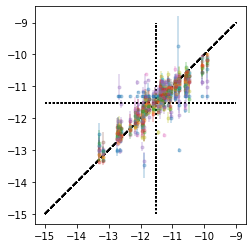

In [381]:
from utils import *
high_binder_cutoff=-5*np.log(10)



traning_RMSE={}
XVals_RMSE={}
XVals_Cor={}
XVals_KT={}
XVals_TPR={}

Val_RMSE={}
Val_Cor={}
Val_KT={}
Val_TPR={}


sfiles = next(os.walk(settings_folder_train_on_expt_ligs), (None, None, []))[2]  # [] if no file
# old_settings_folder=folder+"/meta_param_search/~settings/"
# sfiles = next(os.walk(old_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder_train_on_expt_ligs+"/"+fn
#     settings_fname=old_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception:
            print(f"problem with {fn}")
        if(metrics is not None):
#             print(settings_fname)
            if(settings_loaded[5]!=10):
                continue
#                 key=settings_loaded[1]
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            bi=np.argmin(metrics.loss_XVal)
            #bi=-1

            XVals_RMSE[key]=metrics.RMSD_XVal[bi]
            traning_RMSE[key]=metrics.RMSD_Train[bi]
            XVals_Cor[key]=metrics.Cor_XVal[bi]
            XVals_KT[key]=metrics.kendalltau_XVal[bi]
            XVals_TPR[key]=metrics.TP_XVal[bi]

            # Find predictions for validation ligands
            val_lig_P = metrics.best_pred[0][validation_ids_in_set4f]
            val_lig_uncert = metrics.best_pred[1][validation_ids_in_set4f]
            
            diag = np.linspace(-15,-9, 10)
            plt.plot(diag, diag, '--k', zorder=0)
            plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.errorbar(validation_dGs, val_lig_P, yerr=val_lig_uncert, marker=".", ls='', alpha=0.3)
            plt.gca().set_aspect('equal', 'box')
            
            # compute metrics for validation ligands
            se = np.square(validation_dGs-val_lig_P)
            Val_RMSE[key] = np.sqrt(np.mean(se))
            Val_Cor[key] = np.corrcoef(validation_dGs, val_lig_P)[0,1]
            Val_KT[key] = sp.stats.kendalltau(validation_dGs, val_lig_P)[0]
            _,Val_TPR[key],_ = get_FPR_TPR_AUC(validation_dGs, val_lig_P, high_binder_cutoff)
#             raise()
        else:
            print("Not ready:", settings_fname)



In [382]:
sorted_scan=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
#print(sorted_scan)
#print(list(sorted_scan.keys())[0])
#print(sorted_scan[list(sorted_scan.keys())[0]])

sorted_keys=list(sorted_scan.keys())
#print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'Train RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
print(f"{'REPRESENTATION':^40}\t{'XVal RMSE':^10}\t{'XVal Cor':^10}\t{'XVal Ken.-t':^10}\t{'XVal TPR':^10}")
#for i in range(min(10,len(sorted_scan))):
for i in range(len(sorted_scan)):
    key=sorted_keys[i]
    #if('hlw10' in key):
    #print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{traning_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")
    print(f"{key:40}\t{XVals_RMSE[key]:.4f}\t\t{XVals_Cor[key]:.4f}\t\t{XVals_KT[key]:.4f}\t\t{XVals_TPR[key]:.4f}")

             REPRESENTATION             	XVal RMSE 	 XVal Cor 	XVal Ken.-t	 XVal TPR 
2D_3D_hlw10                             	0.5748		0.6381		0.4812		0.5455
no_core_atom_hot_surf_hlw10             	0.6214		0.6700		0.4517		0.7727
atom_hot_surf_hlw10                     	0.6563		0.5490		0.2652		0.6364
MDenerg_long_cut_hlw10                  	0.6714		0.5996		0.4206		0.6818
atom_hot_hlw10                          	0.6758		0.5582		0.2750		0.5455
no_core_MDenerg_binned_hlw10            	0.6838		0.5425		0.3937		0.7273
no_core_MDenerg_hlw10                   	0.6894		0.5198		0.3155		0.6364
no_core_MDenerg_long_cut_binned_hlw10   	0.6943		0.6096		0.4120		0.7273
no_core_atom_hot_hlw10                  	0.7019		0.5522		0.2750		0.5455
MDenerg_long_cut_binned_hlw10           	0.7383		0.5557		0.4462		0.7727
no_core_MDenerg_long_cut_hlw10          	0.7779		0.5947		0.3195		0.5909
MDenerg_binned_hlw10                    	0.8137		0.2500		0.1469		0.5909
MDenerg_hlw10                           	0.8735		0

# How well do the models predict the binding of the selected step_1 ligands?

### read the simulation dG values and find the tight binders

In [27]:
step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"

with open(step1_db_file, 'rb') as f:
    ligs_step_1 = pickle.load(f)

In [28]:
step_1_smiles=[Chem.MolToSmiles(rdmolops.RemoveHs(lig)) for lig in ligs_step_1]

step_1_ids_in_set4f=[]
step_1_ids_in_step_1_subset=[]

#load only if not curretly loaded
try:
    ligs_set4f
except NameError:
    with open(all_ligs_db_file, 'rb') as f:
        ligs_set4f = pickle.load(f)

for i,lig in enumerate(tqdm(ligs_set4f)):
    smi=Chem.MolToSmiles(rdmolops.RemoveHs(lig))
    if(smi in step_1_smiles):
        step_1_ids_in_set4f.append(i)
        j=step_1_smiles.index(smi)
        step_1_ids_in_step_1_subset.append(j)
        
step_1_ids_in_set4f=np.array(step_1_ids_in_set4f)
step_1_ids_in_step_1_subset=np.array(step_1_ids_in_step_1_subset)

print(f"found {len(step_1_ids_in_set4f)} step_1 ligands")

100%|██████████| 34114/34114 [00:28<00:00, 1204.75it/s]

found 99 step_1 ligands


In [38]:
# print(step_1_ids_in_set4f)
# print(step_1_ids_in_step_1_subset)

In [29]:
step_1_sim_dGs=np.array([float(ligs_step_1[j].GetProp('dG')) for j in step_1_ids_in_step_1_subset ])
# print(step_1_sim_dGs)

In [30]:
training_ligand_databse_fn="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket_4d09_protein/processed_69_cl13_ligs_in_4d09_for_ddG_calc.pickle"
with open(training_ligand_databse_fn, 'rb') as f:
    training_ligs = pickle.load(f)

reference_lig_name="JAN_PDE2_1345"
for i,l in enumerate(training_ligs):
    if(reference_lig_name in l.GetProp("ID")):
        reference_lig=l
        
del training_ligs
_=gc.collect()
        
cal2J = 4.184
def lig_to_dG(lig):
    RT=0.001985875*300 #kcal/mol
    return(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10))
ref_dG=lig_to_dG(reference_lig)

cutoff_ddg=-16/cal2J # kcal/mol
cutoff_dG=ref_dG+cutoff_ddg
print(cutoff_dG)

-14.633827327745813


In [85]:
step_1_tight_binders_ids_in_set4f=[]
step_1_tight_binders_ids_in_step_1=[]
step_1_tight_binders_dGs=[]
step_1_tight_binders=[]
for i in range(len(step_1_ids_in_step_1_subset)):
    in_step_1=step_1_ids_in_step_1_subset[i]
    in_set4f =step_1_ids_in_set4f[i]
    
    if(step_1_sim_dGs[i]<=cutoff_dG):
#         step_1_tight_binders_ids_in_step_1.append(in_step_1)
        step_1_tight_binders_ids_in_set4f.append(in_set4f)
        step_1_tight_binders_dGs.append(step_1_sim_dGs[i])
        step_1_tight_binders_ids_in_step_1.append(in_step_1)
        #step_1_tight_binders.append(ligs_step_1[in_step_1])
        step_1_tight_binders.append(Chem.MolFromSmiles(Chem.MolToSmiles(ligs_step_1[in_step_1])))
        
step_1_tight_binders_ids_in_set4f=np.array(step_1_tight_binders_ids_in_set4f)
step_1_tight_binders_ids_in_step_1=np.array(step_1_tight_binders_ids_in_step_1)
step_1_tight_binders_dGs=np.array(step_1_tight_binders_dGs)
        
print(step_1_tight_binders_dGs)
print(step_1_tight_binders_ids_in_step_1)
        
# Draw.MolsToGridImage(step_1_tight_binders,
#                      subImgSize = (200,200), molsPerRow=5, maxMols=101)

[-15.87586047 -17.73134167 -16.80081267 -15.19310075 -15.76432446
 -14.81228494 -14.73819317 -15.20345767 -15.64880502 -15.89259087
 -15.59861382]
[62 23  3 20 27 38 31 26 37 44 52]


In [32]:
del step_1_smiles, ligs_step_1
_=gc.collect()

### how well do the models predict these ligands?

In [33]:
# step_1_ids_in_set4f, step_1_sim_dGs
# step_1_tight_binders_ids_in_set4f, step_1_tight_binders_dGs

cutoff_dG = -14.633827327745813

100%|██████████| 30/30 [00:00<00:00, 49.60it/s]


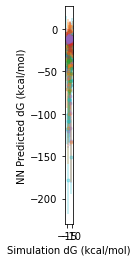

In [93]:
from utils import *
#high_binder_cutoff=-5*np.log(10)
high_binder_cutoff=cutoff_dG


traning_RMSE={}
XVals_RMSE={}
XVals_Cor={}
XVals_KT={}
XVals_TPR={}

Pred_RMSE={}
Pred_Cor={}
Pred_KT={}
Pred_TPR={}

TightPred_RMSE={}
TightPred_Cor={}
TightPred_KT={}
TightPred_TPR={}

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
# old_settings_folder=folder+"/meta_param_search/~settings/"
# sfiles = next(os.walk(old_settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
#     settings_fname=old_settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception as e:
            print(f"problem with {settings_fname}")
            raise(e)
        if(metrics is not None):
            if(settings_loaded[5]!=10):
                continue
#                 key=settings_loaded[1]
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
            bi=np.argmin(metrics.loss_XVal)
            #bi=-1

            XVals_RMSE[key]=metrics.RMSD_XVal[bi]
            traning_RMSE[key]=metrics.RMSD_Train[bi]
            XVals_Cor[key]=metrics.Cor_XVal[bi]
            XVals_KT[key]=metrics.kendalltau_XVal[bi]
            XVals_TPR[key]=metrics.TP_XVal[bi]
            
            ###############
            use_ids=step_1_ids_in_set4f
            use_dGs=step_1_sim_dGs

            # Find predictions for validation ligands
            pred_lig_P = metrics.best_pred[0][use_ids]
            pred_lig_uncert = metrics.best_pred[1][use_ids]
            
            diag = np.linspace(-15,-9, 10)
            plt.plot(diag, diag, '--k', zorder=0)
            plt.vlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.hlines(high_binder_cutoff, -15,-9, colors='k', linestyles='dotted', label='')
            plt.errorbar(use_dGs, pred_lig_P, yerr=pred_lig_uncert, marker=".", ls='', alpha=0.3)
            plt.gca().set_aspect('equal', 'box')
            plt.xlabel("Simulation dG (kcal/mol)")
            plt.ylabel("NN Predicted dG (kcal/mol)")
            
            # compute metrics for validation ligands
            se = np.square(use_dGs-pred_lig_P)
            Pred_RMSE[key] = np.sqrt(np.mean(se))
            Pred_Cor[key] = np.corrcoef(use_dGs, pred_lig_P)[0,1]
            Pred_KT[key] = sp.stats.kendalltau(use_dGs, pred_lig_P)[0]
            _,Pred_TPR[key],_ = get_FPR_TPR_AUC(use_dGs, pred_lig_P, high_binder_cutoff)
            
            ###############
            use_ids=step_1_tight_binders_ids_in_set4f
            use_dGs=step_1_tight_binders_dGs
            
            # Find predictions for validation ligands
            pred_lig_P = metrics.best_pred[0][use_ids]
            pred_lig_uncert = metrics.best_pred[1][use_ids]
            
            # compute metrics for validation ligands
            se = np.square(use_dGs-pred_lig_P)
            TightPred_RMSE[key] = np.sqrt(np.mean(se))
            TightPred_Cor[key] = np.corrcoef(use_dGs, pred_lig_P)[0,1]
            TightPred_KT[key] = sp.stats.kendalltau(use_dGs, pred_lig_P)[0]
            _,TightPred_TPR[key],_ = get_FPR_TPR_AUC(use_dGs, pred_lig_P, high_binder_cutoff)
#             raise()



In [94]:
sorted_scan=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))

In [95]:
sorted_RMSE=dict(sorted(XVals_RMSE.items(), key=lambda item: item[1]))
sorted_Cor= dict(sorted(XVals_Cor.items(), key=lambda item: item[1]))
sorted_KT=  dict(sorted(XVals_KT.items(), key=lambda item: item[1]))
sorted_TPR= dict(sorted(XVals_TPR.items(), key=lambda item: item[1]))

from sklearn.cluster import KMeans
nranks=5
#def rank_by_kmeans(d, nranks=10):
def rank_by_kmeans(d, nranks=nranks):
    X = np.array([[v[1]] for v in d.items()])
    kmeans = KMeans(n_clusters=nranks, random_state=0).fit(X)
    sorted_cl_ids=np.argsort(kmeans.cluster_centers_.flatten())
    #print(kmeans.cluster_centers_[sorted_cl_ids])
    rank_from_cl_id={}
    for i,j in enumerate(sorted_cl_ids):
        rank_from_cl_id[j]=i
    
    ret={}
    for i,key in enumerate(d.keys()):
        ret[key]=rank_from_cl_id[kmeans.labels_[i]]
    return(ret)

rank_RMSE=rank_by_kmeans(sorted_RMSE)
rank_Cor=rank_by_kmeans(sorted_Cor)
rank_KT=rank_by_kmeans(sorted_KT)
rank_TPR=rank_by_kmeans(sorted_TPR)


rank={}
for key in rank_RMSE.keys():
    rank[key]=rank_RMSE[key]+(nranks-1-rank_Cor[key])+(nranks-1-rank_KT[key])+(nranks-1-rank_TPR[key])

sorted_rank= dict(sorted(rank.items(), key=lambda item: item[1]))
keys=list(sorted_rank.keys())


print(f"{'RANK':^4}\t{'REPRESENTATION':^32}\t{'XVal RMSE':^10} {'XVal Cor':^10} {'XVal Ken.-t':^10} {'XVal TPR':^10}"+
      f"|\t{'s_1 RMSE':^10} {'s_1 Cor':^10} {'s_1 Ken.-t':^10} {'s_1 TPR':^10} "+
      f"|\t{'Tight RMSE':^10} {'Tight Cor':^10} {'Tight Ken.-t':^10} {'Pred TPR':^10}")
for i in range(len(sorted_RMSE)):
    key=keys[i]
    r=rank[key]
    print(f"{r:4}\t{key:32}\t{XVals_RMSE[key]:10.2f} {XVals_Cor[key]:10.2} {XVals_KT[key]:10.2f} {XVals_TPR[key]:10.2f} "+
          f"|\t{Pred_RMSE[key]:10.2f} {Pred_Cor[key]:10.2f} {Pred_KT[key]:10.2f} {Pred_TPR[key]:10.2f} "+
          f"|\t{TightPred_RMSE[key]:10.2f} {TightPred_Cor[key]:10.2f} {TightPred_KT[key]:10.2f} {TightPred_TPR[key]:10.2f}")

RANK	         REPRESENTATION         	XVal RMSE   XVal Cor  XVal Ken.-t  XVal TPR |	 s_1 RMSE   s_1 Cor   s_1 Ken.-t  s_1 TPR   |	Tight RMSE Tight Cor  Tight Ken.-t  Pred TPR 
   2	2D_3D_hlw10                     	      2.04       0.33       0.26       0.66 |	      2.12       0.57       0.40       0.73 |	      2.18      -0.16      -0.20       0.73
   3	no_core_MDenerg_binned_hlw10    	      2.18       0.28       0.19       0.74 |	     37.70       0.04      -0.03       0.36 |	     31.15       0.12       0.24       0.36
   4	no_core_atom_hot_surf_hlw10     	      1.99       0.22       0.17       0.63 |	      3.61       0.24       0.18       0.27 |	      2.48      -0.10       0.02       0.27
   4	MDenerg_long_cut_hlw10          	      2.33       0.17       0.21       0.82 |	      7.98      -0.13      -0.10       0.27 |	      4.21       0.42      -0.05       0.27
   5	no_core_MDenerg_long_cut_hlw10  	      2.21       0.18       0.10       0.70 |	      9.66      -0.16      -0.14       0.36 

## Predictions of tight binders from different models

In [80]:
TightPred_dGs={}
TightPred_uncert={}

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory
for fn in tqdm(sfiles):
    settings_fname=settings_folder+"/"+fn
    with open(settings_fname, 'rb') as f:
        metrics=None
        try:
            settings_loaded, metrics = pickle.load(f)
        except Exception as e:
            print(f"problem with {settings_fname}")
            raise(e)
        if(metrics is not None):
            if(settings_loaded[5]!=10):
                continue
            key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
                        
            ###############
            use_ids=step_1_tight_binders_ids_in_set4f
            
            TightPred_dGs[key] = metrics.best_pred[0][use_ids]
            TightPred_uncert[key] = metrics.best_pred[1][use_ids]

100%|██████████| 30/30 [00:00<00:00, 365.19it/s]


In [98]:
# step_1_tight_binders, TightPred_dGs, TightPred_uncert
use_keys = ['2D_3D_hlw10', 'no_core_MDenerg_binned_hlw10', 'no_core_atom_hot_surf_hlw10', 'MDenerg_long_cut_hlw10', 'no_core_MDenerg_long_cut_hlw10']

step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
with open(step1_db_file, 'rb') as f:
    ligs_step_1 = pickle.load(f)

legends =[]
for j,i in enumerate(step_1_tight_binders_ids_in_step_1):
    l=ligs_step_1[i]
#     print(j,i)
    lbl=l.GetProp('ID')
    lbl+=f"\nSim dG: {float(l.GetProp('dG')):5.2f}±{float(l.GetProp('dG_err')):4.2f}"
    temp_tight_dgs.append(float(l.GetProp('dG')))
    for key in use_keys:
        lbl+=f"\n{key}: {TightPred_dGs[key][j]:5.2f}±{TightPred_uncert[key][j]:5.2f}"
        
    legends.append(lbl)

del ligs_step_1
_=gc.collect()

In [106]:
step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
with open(step1_db_file, 'rb') as f:
    ligs_step_1 = pickle.load(f)
    
print([ligs_step_1[i].GetProp('ID') for i in step_1_tight_binders_ids_in_step_1])
print([ligs_set4f[i].GetProp('ID') for i in step_1_tight_binders_ids_in_set4f])

del ligs_step_1
_=gc.collect()

['set4_12861', 'set4_20500', 'set4_28086', 'set4_72021', 'set4_202093', 'set4_282772', 'set4_284724', 'set4_316514', 'set4_318411', 'set4_376018', 'set4_376050']
['set4_12861', 'set4_20500', 'set4_28086', 'set4_72021', 'set4_202093', 'set4_282772', 'set4_284724', 'set4_316514', 'set4_318411', 'set4_376018', 'set4_376050']


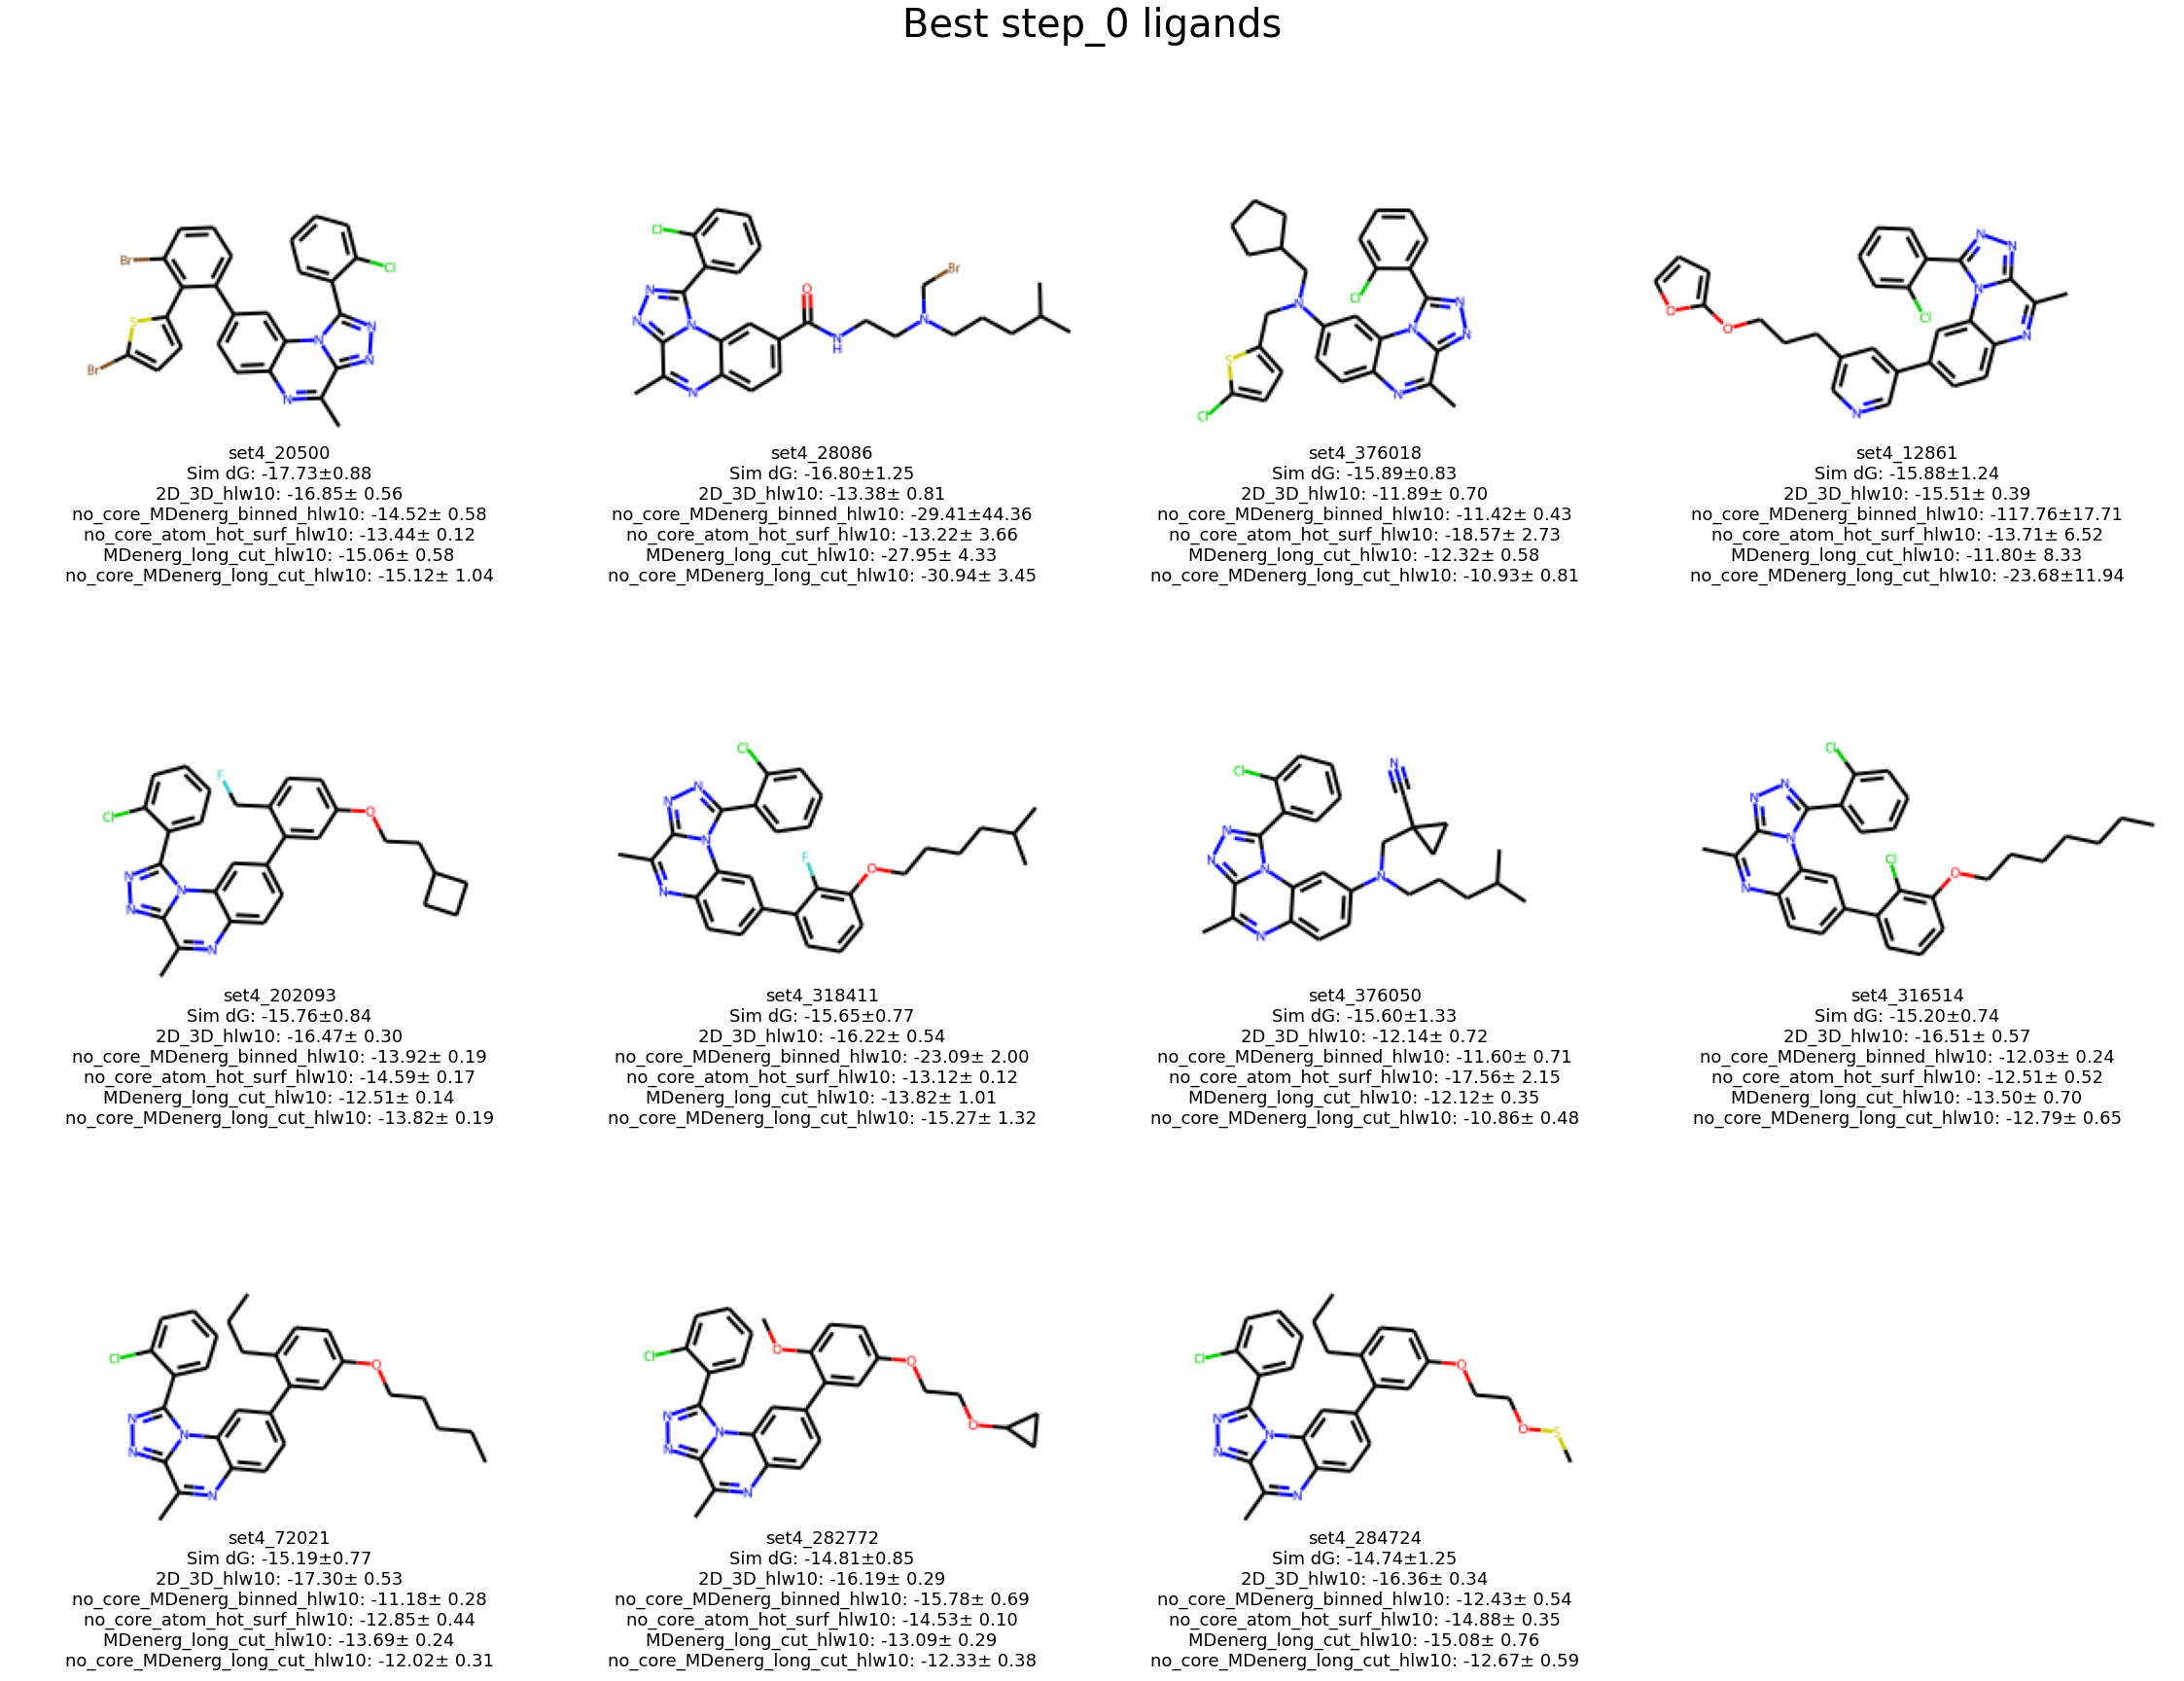

In [107]:
# based on https://github.com/rdkit/rdkit/issues/3093#issuecomment-848204813
def grid_mols_with_annotation(mols, labels, sub_img_size=250, mols_per_row=5, title="", annotation_size=20, title_size=25, y_offset=-20):
    """Annotates a MolsToGridImage given a set of labels for each mol with better font size options and title"""
    
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(sub_img_size, sub_img_size), returnPNG=False)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title(title, fontsize=title_size)
    text_pos = (sub_img_size/2, sub_img_size+y_offset)
    pos_ctr = 0
    plt.axis("off")
    for cmpd_text in labels:
        plt.annotate(cmpd_text, text_pos, fontsize=annotation_size, horizontalalignment='center')
        pos_ctr += 1
        text_pos = (text_pos[0]+sub_img_size, text_pos[1])
        if (pos_ctr % mols_per_row) == 0:
            text_pos = (sub_img_size/2, text_pos[1] + sub_img_size)

    ax.imshow(img, origin="upper")
    
grid_mols_with_annotation(
        [step_1_tight_binders[i] for i in order],
        [legends[i] for i in order],
        title="Best step_0 ligands", title_size=40,
        sub_img_size=300, annotation_size=18, y_offset=-5, mols_per_row=4)

### debug

In [99]:
temp_tight_dgs=np.array(temp_tight_dgs)
print(temp_tight_dgs)

[-15.87586047 -17.73134167 -16.80081267 -15.19310075 -15.76432446
 -14.81228494 -14.73819317 -15.20345767 -15.64880502 -15.89259087
 -15.59861382]


In [100]:
order = np.argsort(temp_tight_dgs)
print(order)
print(temp_tight_dgs[order])

[ 1  2  9  0  4  8 10  7  3  5  6]
[-17.73134167 -16.80081267 -15.89259087 -15.87586047 -15.76432446
 -15.64880502 -15.59861382 -15.20345767 -15.19310075 -14.81228494
 -14.73819317]


## embeding visualisation

In [135]:
spe1=np.array([float(ligs_set4f[i].GetProp('2D_no_core t-SNE 1')) for i in step_1_tight_binders_ids_in_set4f])
spe2=np.array([float(ligs_set4f[i].GetProp('2D_no_core t-SNE 2')) for i in step_1_tight_binders_ids_in_set4f])

step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
with open(step1_db_file, 'rb') as f:
    ligs_step_1 = pickle.load(f)
    
tight_calc_dG=np.array([float(ligs_step_1[i].GetProp('dG')) for i in step_1_tight_binders_ids_in_step_1])

del ligs_step_1
_=gc.collect()

other_ids_in_set4f=[i for i in range(len(ligs_set4f)) if i not in step_1_tight_binders_ids_in_set4f]
grey_spe1=np.array([float(ligs_set4f[i].GetProp('2D_no_core t-SNE 1')) for i in other_ids_in_set4f])
grey_spe2=np.array([float(ligs_set4f[i].GetProp('2D_no_core t-SNE 2')) for i in other_ids_in_set4f])

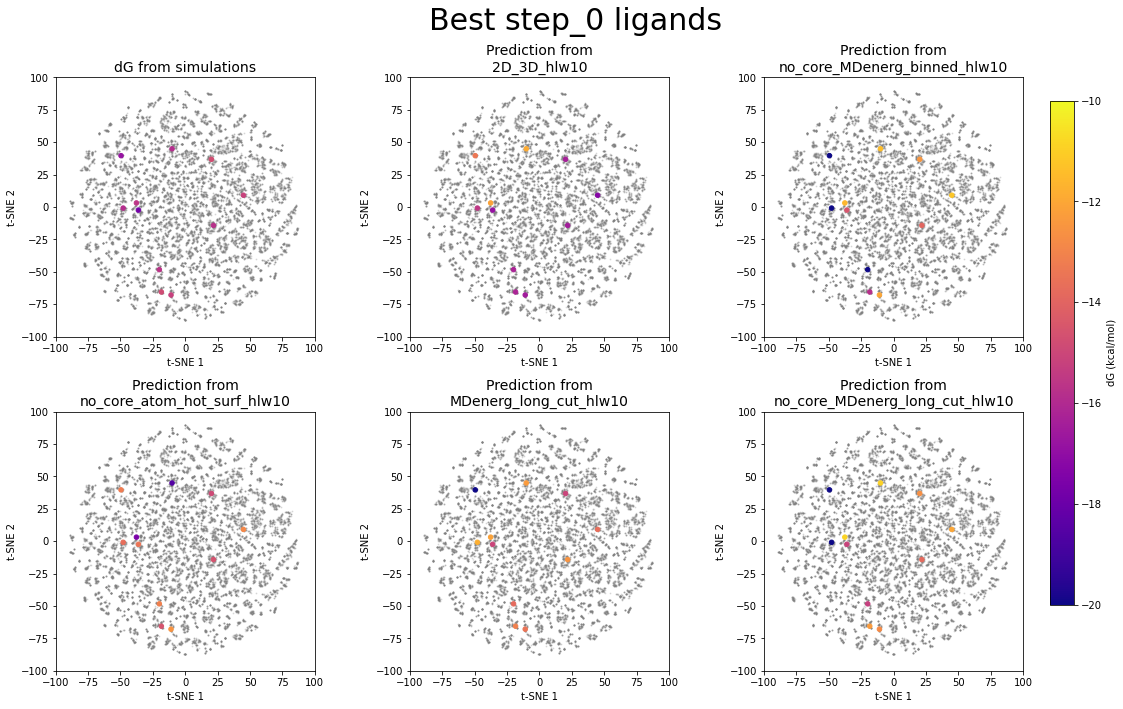

In [168]:
fig, axs = plt.subplots(2, 3, figsize=[(5+0.5)*3, 5*2])
#fig, axs = plt.subplots(2, 2, figsize=[8, 8])
limsx=(-100,100)
lims2=[limsx,limsx]

vmax=-10
vmin=-20

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.suptitle("Best step_0 ligands", fontsize=30)

# calc
axs[0, 0].set_aspect('equal', 'box')
axs[0, 0].set_title("dG from simulations", fontsize=14)
axs[0, 0].set_xlim(limsx)
axs[0, 0].set_ylim(limsx)
axs[0, 0].set_xlabel("t-SNE 1")
axs[0, 0].set_ylabel("t-SNE 2")
_=axs[0, 0].scatter(grey_spe1, grey_spe2, c='grey', alpha=0.1, s=1)
_=axs[0, 0].scatter(spe1, spe2, c=tight_calc_dG, cmap="plasma", vmin=vmin, vmax=vmax, s=20)

# calc
sx=1
sy=0
for key in use_keys:
    axs[sy, sx].set_aspect('equal', 'box')
    axs[sy, sx].set_title(f"Prediction from\n{key}", fontsize=14)
    axs[sy, sx].set_xlim(limsx)
    axs[sy, sx].set_ylim(limsx)
    axs[sy, sx].set_xlabel("t-SNE 1")
    axs[sy, sx].set_ylabel("t-SNE 2")
    _=axs[sy, sx].scatter(grey_spe1, grey_spe2, c='grey', alpha=0.1, s=1)
    _=axs[sy, sx].scatter(spe1, spe2, c=TightPred_dGs[key], cmap="plasma", vmin=vmin, vmax=vmax, s=20)
    
    sx+=1
    if(sx>=3):
        sx=0
        sy+=1


plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(_, cax=cbar_ax)
cbar_ax.set_ylabel('dG (kcal/mol)')

plt.show()

-17.300695 -6.520143
-178.21298 -6.0075545
-22.336864 3.940068
-34.6587 12.242308
-49.509167 -7.175557


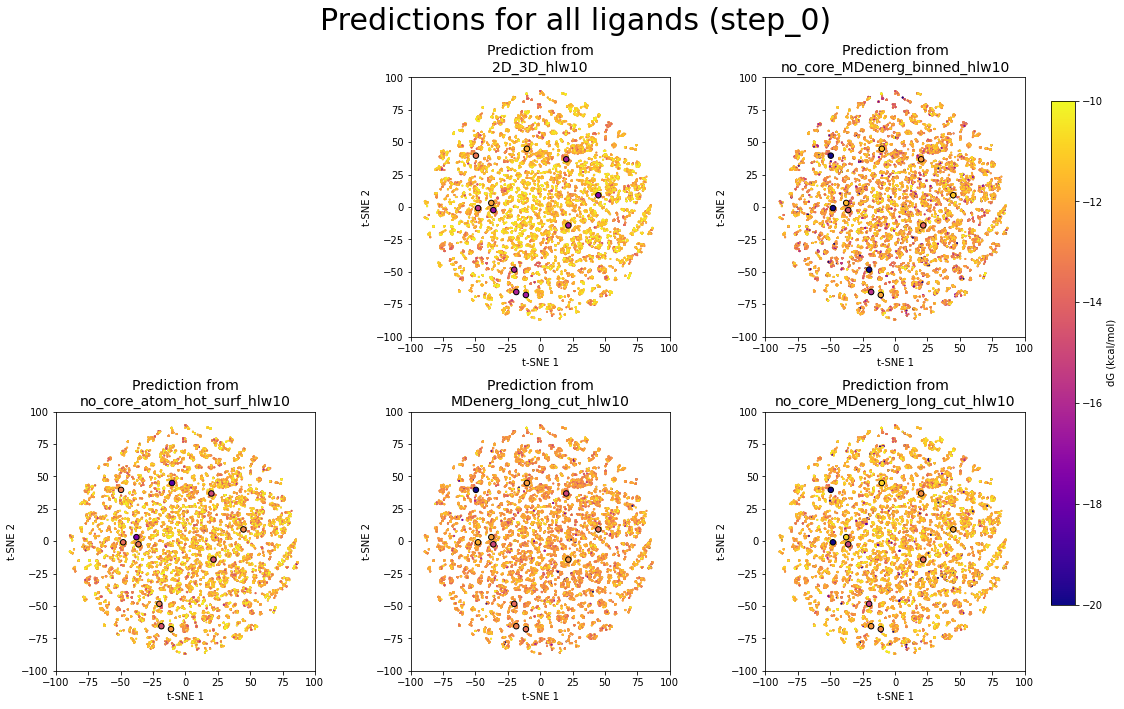

In [181]:
all_spe1=np.array([float(l.GetProp('2D_no_core t-SNE 1')) for l in ligs_set4f])
all_spe2=np.array([float(l.GetProp('2D_no_core t-SNE 2')) for l in ligs_set4f])

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory




fig, axs = plt.subplots(2, 3, figsize=[(5+0.5)*3, 5*2])
#fig, axs = plt.subplots(2, 2, figsize=[8, 8])
limsx=(-100,100)
lims2=[limsx,limsx]

vmax=-10
vmin=-20

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.suptitle("Predictions for all ligands (step_0)", fontsize=30)

axs[0, 0].axis('off')


sx=1
sy=0
for key in use_keys:
    c=None
    probed=None
    
    for fn in sfiles:
        settings_fname=settings_folder+"/"+fn
        with open(settings_fname, 'rb') as f:
            metrics=None
            try:
                settings_loaded, metrics = pickle.load(f)
            except Exception as e:
                print(f"problem with {settings_fname}")
                raise(e)
            if(metrics is not None):
                if(settings_loaded[5]!=10):
                    continue
                this_key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
                if(this_key==key):
                    c=metrics.best_pred[0]
    
    axs[sy, sx].set_aspect('equal', 'box')
    axs[sy, sx].set_title(f"Prediction from\n{key}", fontsize=14)
    axs[sy, sx].set_xlim(limsx)
    axs[sy, sx].set_ylim(limsx)
    axs[sy, sx].set_xlabel("t-SNE 1")
    axs[sy, sx].set_ylabel("t-SNE 2")
    _=axs[sy, sx].scatter(all_spe1, all_spe2, c=c, cmap="plasma", vmin=vmin, vmax=vmax, s=1)
    _=axs[sy, sx].scatter(spe1, spe2, c=TightPred_dGs[key], cmap="plasma", vmin=vmin, vmax=vmax, s=30, edgecolors='black')
    
    print(np.min(c), np.max(c))
    
    sx+=1
    if(sx>=3):
        sx=0
        sy+=1


plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(_, cax=cbar_ax)
cbar_ax.set_ylabel('dG (kcal/mol)')

plt.show()

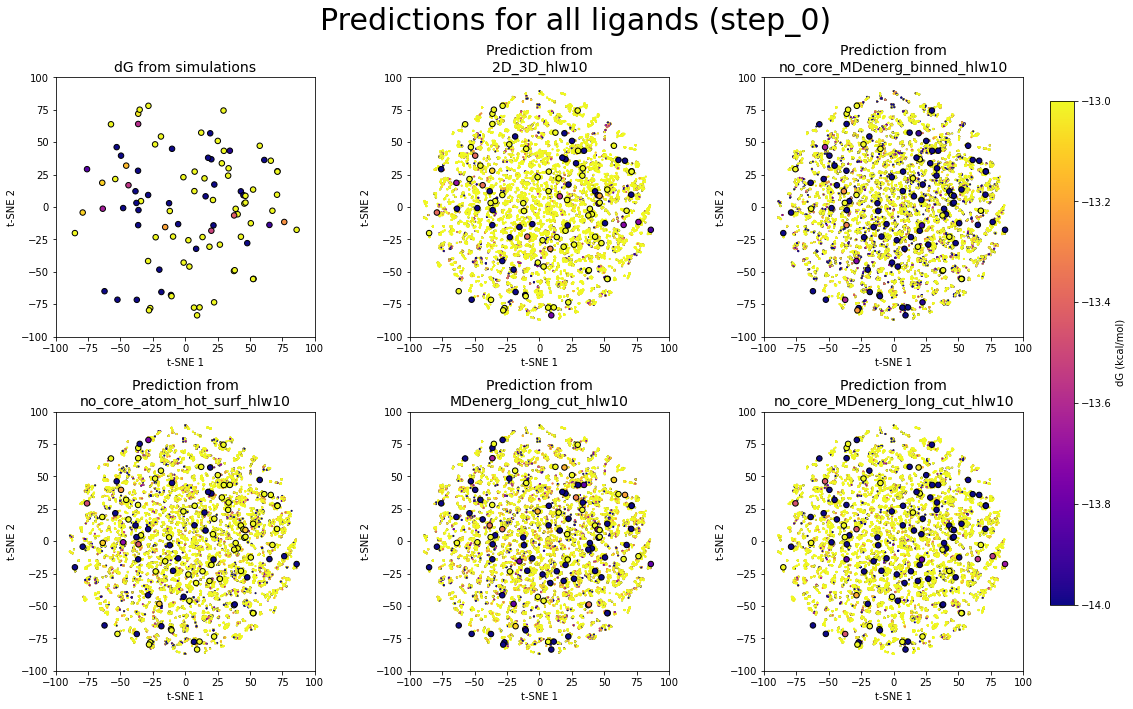

In [198]:
# all_spe1=np.array([float(l.GetProp('2D_no_core t-SNE 1')) for l in ligs_set4f])
# all_spe2=np.array([float(l.GetProp('2D_no_core t-SNE 2')) for l in ligs_set4f])

probed_spe1=np.array([float(ligs_set4f[i].GetProp('2D_no_core t-SNE 1')) for i in step_1_ids_in_set4f])
probed_spe2=np.array([float(ligs_set4f[i].GetProp('2D_no_core t-SNE 2')) for i in step_1_ids_in_set4f])


sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory




fig, axs = plt.subplots(2, 3, figsize=[(5+0.5)*3, 5*2], facecolor='w')
#fig, axs = plt.subplots(2, 2, figsize=[8, 8])
limsx=(-100,100)
lims2=[limsx,limsx]

#vmax=-10
#vmin=-20
vmax=-13
vmin=-14
cmap="plasma"
#cmap="jet"

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.suptitle("Predictions for all ligands (step_0)", fontsize=30)

# axs[0, 0].axis('off')

# calc
step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
with open(step1_db_file, 'rb') as f:
    ligs_step_1 = pickle.load(f)
probed=np.array([float(ligs_step_1[i].GetProp('dG')) for i in step_1_ids_in_step_1_subset])
del ligs_step_1
_=gc.collect()

axs[0, 0].set_aspect('equal', 'box')
axs[0, 0].set_title("dG from simulations", fontsize=14)
axs[0, 0].set_xlim(limsx)
axs[0, 0].set_ylim(limsx)
axs[0, 0].set_xlabel("t-SNE 1")
axs[0, 0].set_ylabel("t-SNE 2")
_=axs[0, 0].scatter(probed_spe1, probed_spe2, c=probed, cmap=cmap, vmin=vmin, vmax=vmax, s=30, edgecolors='black')


sx=1
sy=0
for key in use_keys:
    c=None
    probed=None
    
    for fn in sfiles:
        settings_fname=settings_folder+"/"+fn
        with open(settings_fname, 'rb') as f:
            metrics=None
            try:
                settings_loaded, metrics = pickle.load(f)
            except Exception as e:
                print(f"problem with {settings_fname}")
                raise(e)
            if(metrics is not None):
                if(settings_loaded[5]!=10):
                    continue
                this_key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
                if(this_key==key):
                    c=metrics.best_pred[0]
                    probed=metrics.best_pred[0][step_1_ids_in_set4f]
    
    axs[sy, sx].set_aspect('equal', 'box')
    axs[sy, sx].set_title(f"Prediction from\n{key}", fontsize=14)
    axs[sy, sx].set_xlim(limsx)
    axs[sy, sx].set_ylim(limsx)
    axs[sy, sx].set_xlabel("t-SNE 1")
    axs[sy, sx].set_ylabel("t-SNE 2")
    _=axs[sy, sx].scatter(all_spe1, all_spe2, c=c, cmap=cmap, vmin=vmin, vmax=vmax, s=1)
    _=axs[sy, sx].scatter(probed_spe1, probed_spe2, c=probed, cmap=cmap, vmin=vmin, vmax=vmax, s=30, edgecolors='black')
    
#     print(np.min(c), np.max(c))
    
    sx+=1
    if(sx>=3):
        sx=0
        sy+=1


plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(_, cax=cbar_ax)
cbar_ax.set_ylabel('dG (kcal/mol)')

plt.show()

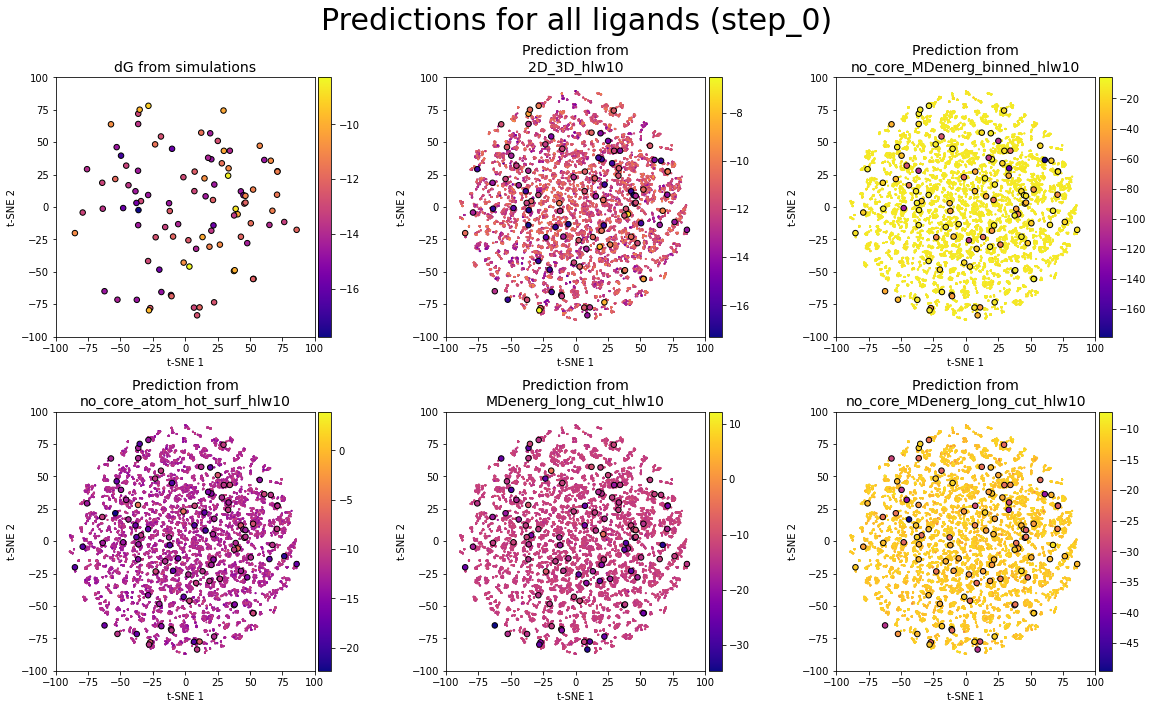

In [192]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sfiles = next(os.walk(settings_folder), (None, None, []))[2]  # [] if no file
sfiles=[f for f in sfiles if f[0]!='.'] # skip hidden files like .directory




fig, axs = plt.subplots(2, 3, figsize=[(5+0.5)*3, 5*2])
#fig, axs = plt.subplots(2, 2, figsize=[8, 8])
limsx=(-100,100)
lims2=[limsx,limsx]

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.suptitle("Predictions for all ligands (step_0)", fontsize=30)

# axs[0, 0].axis('off')

# calc
step1_db_file=f"{pocket_fit_folder}/ddG_step_1_sigmahole_scaled_dummy_masses/stable_ligs.pickle"
with open(step1_db_file, 'rb') as f:
    ligs_step_1 = pickle.load(f)
probed=np.array([float(ligs_step_1[i].GetProp('dG')) for i in step_1_ids_in_step_1_subset])
del ligs_step_1
_=gc.collect()

axs[0, 0].set_aspect('equal', 'box')
axs[0, 0].set_title("dG from simulations", fontsize=14)
axs[0, 0].set_xlim(limsx)
axs[0, 0].set_ylim(limsx)
axs[0, 0].set_xlabel("t-SNE 1")
axs[0, 0].set_ylabel("t-SNE 2")
vmin=np.min(probed)
vmax=np.max(probed)
_=axs[0, 0].scatter(probed_spe1, probed_spe2, c=probed, cmap="plasma", vmin=vmin, vmax=vmax, s=30, edgecolors='black')
divider = make_axes_locatable( axs[0, 0] )
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(_, cax=cax, orientation='vertical')


sx=1
sy=0
for key in use_keys:
    c=None
    
    for fn in sfiles:
        settings_fname=settings_folder+"/"+fn
        with open(settings_fname, 'rb') as f:
            metrics=None
            try:
                settings_loaded, metrics = pickle.load(f)
            except Exception as e:
                print(f"problem with {settings_fname}")
                raise(e)
            if(metrics is not None):
                if(settings_loaded[5]!=10):
                    continue
                this_key=f"{settings_loaded[1]}_hlw{settings_loaded[5]}"
                if(this_key==key):
                    c=metrics.best_pred[0]
                    probed=metrics.best_pred[0][step_1_ids_in_set4f]
    
    axs[sy, sx].set_aspect('equal', 'box')
    axs[sy, sx].set_title(f"Prediction from\n{key}", fontsize=14)
    axs[sy, sx].set_xlim(limsx)
    axs[sy, sx].set_ylim(limsx)
    axs[sy, sx].set_xlabel("t-SNE 1")
    axs[sy, sx].set_ylabel("t-SNE 2")
    vmin=np.min(c)
    vmax=np.max(c)
    _=axs[sy, sx].scatter(all_spe1, all_spe2, c=c, cmap="plasma", vmin=vmin, vmax=vmax, s=1)
#     _=axs[sy, sx].scatter(spe1, spe2, c=TightPred_dGs[key], cmap="plasma", vmin=vmin, vmax=vmax, s=30, edgecolors='black')
    _=axs[sy, sx].scatter(probed_spe1, probed_spe2, c=probed, cmap="plasma", vmin=vmin, vmax=vmax, s=30, edgecolors='black')
    
    divider = make_axes_locatable( axs[sy, sx] )
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(_, cax=cax, orientation='vertical')
    
#     print(np.min(c), np.max(c))
    
    sx+=1
    if(sx>=3):
        sx=0
        sy+=1


plt.tight_layout()
# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# fig.colorbar(_, cax=cbar_ax)
# cbar_ax.set_ylabel('dG (kcal/mol)')

plt.show()

# Explaining NN with embedding
Stick to 2D_3D for now

## Get final layer inputs for each model and ligand

In [200]:
import NNs
from NNs import *

# load NN
model_folder=f"{pocket_fit_folder}/prediction_step_0/repr_scan_step_0_on_preliminary_calc_ddG/meta_param_search/models/2D_3D/known_99_width_10_depth_2_trd_10000_wd_0.001_norm_X_weightedbyY_dropout0.5_shiftY_20000ep/"
settings_hash='0ee2158e18'

for i_m in range(5):
    fn=f"{model_folder}/training_models/model_{i_m}_{settings_hash}_best_so_far.pickle"
    model = Net(inp_width=n_features, hl_w=hl_w, nhl=hl_depth, activation="relu",
                    learning_rate=init_learning_rate, lr_decay=learning_rate_decay,
                    high_binder_cutoff=high_binder_cutoff, weight_decay=weight_decay,
                    weights_distrib_func=weight_func, drop_p=p_dropout, noise=0.0, shiftY=shiftY).to(device)
